In [1]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
#%matplotlib widget 

In [3]:
from mppi import Utilities as U, Parsers as P
import mppi.Utilities.Tools as T
import matplotlib.pyplot as plt
import yaml
from matplotlib import gridspec
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition,inset_axes
import numpy as np
from scipy.signal import argrelextrema
from scipy.optimize import curve_fit
from scipy.integrate import simps
from scipy.interpolate import interp1d
h = U.Constants.Planck_ev_ps*1e3 # eV*fs

import yaml

# Plots

This notebook collects an extended analysis of the results of the QE and RT computations.

## Band structure, JDOS and Absorption

We plot the band structure on the high sym line of the BZ

In [4]:
bands_file = 'QE_bands/bands.save/data-file-schema.xml'
hsp = U.Constants.high_sym_fcc

In [5]:
bands = U.BandStructure.from_Pw(bands_file,hsp,set_gap=1.42)

Apply a scissor of 0.9547660195971783 eV


In [6]:
hs_positions = bands.get_high_sym_positions()
print(hs_positions)

kspan = 0.06 #in unit of 2pi/alat
k0 = 0.8660254037844385

(['G', 'G', 'X', 'L', 'K'], [0.8660254037844385, 4.28023896615753, 1.8660254037844377, 0.0, 2.866025403784435])


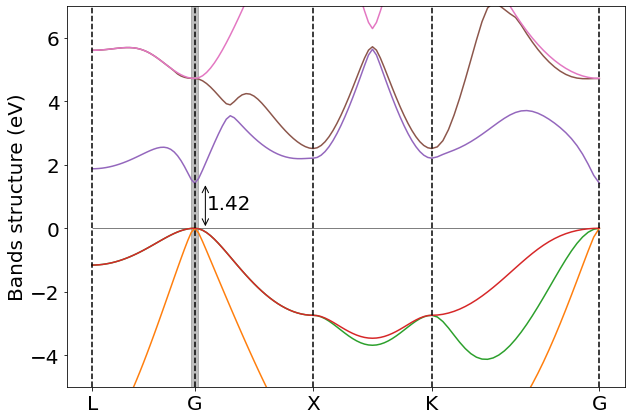

In [7]:
label_size = 20

fig, ax = plt.subplots(figsize=(10, 7))
ax.set_ylim(-5,7)
bands.plot(plt,selection=[i for i in range(0,7)])
ax.annotate('', xy=(k0+0.09, 0), xytext=(k0+0.09, 1.42), arrowprops=dict(arrowstyle='<->'),size=16)
ax.text(k0+0.1,0.6,'1.42',size=label_size)
ax.axvspan(k0-kspan/2, k0+kspan/2, alpha=0.5, color='gray')
ax.hlines(0.,0.,4.28,linestyles='-',color='gray',linewidth=1)
ax.set_ylabel('Bands structure (eV)',size=label_size)
ax.tick_params(axis='both', which='major', labelsize=label_size)

#plt.savefig(fname='Plot/band_structure.eps',format='eps',bbox_inches = "tight")

We plot the JDOS computed in the random grid sampling close to $\Gamma$

In [8]:
file = 'NSCF/bnds_8-kpoints_1000-sampling_random_close_Gamma_kspan0.06.save/data-file-schema.xml'

In [9]:
data = P.PwParser(file)

Parse file : NSCF/bnds_8-kpoints_1000-sampling_random_close_Gamma_kspan0.06.save/data-file-schema.xml


We compute the energy spread of the transitions

In [10]:
trans_vtoc1 = data.get_transitions(initial=[1,2,3],final=[4],set_gap=1.42)
trans_vtoc2 = data.get_transitions(initial=[1,2,3],final=[5],set_gap=1.42)
trans_c1toc2 = data.get_transitions(initial=[4],final=[5],set_gap=1.42)

#trans = data.get_transitions(initial=[1,2,3],final=[4,5],set_gap=1.42)

In [11]:
1/250

0.004

In [12]:
dos = U.Dos()
#dos.append(trans.flatten(),minVal=0,maxVal=5,eta=1e-3)
dos.append(trans_vtoc1.flatten(),minVal=0,maxVal=3,eta=1.6e-2,label='v to c$_1$')
dos.append(trans_vtoc2.flatten(),minVal=2,maxVal=6,eta=1e-3,label='v to c$_2$')
dos.append(trans_c1toc2.flatten(),minVal=2,maxVal=4,eta=1e-3,label='c$_1$ to c$_2$')

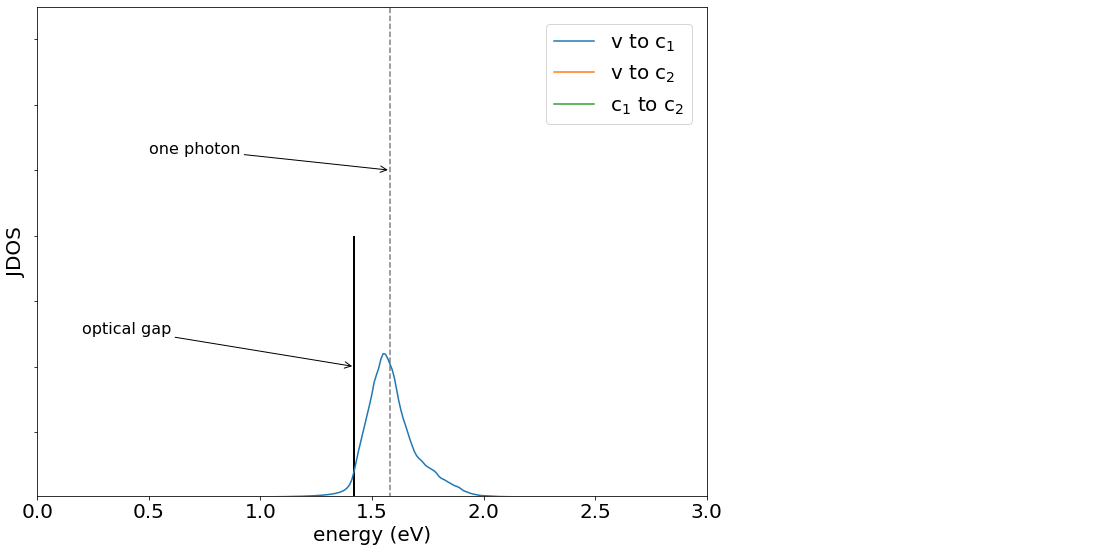

In [13]:
label_size = 20

fig, ax = plt.subplots(figsize=(12, 9))
dos.plot(plt,rescale=False)
ax.vlines([1.58,1.58*2,1.58*3],-1,30,linestyle='--',color='gray')
ax.set_ylim(0.05,15)
ax.set_xlim(0,3) #6.5)
ax.set_xlabel('energy (eV)',size=label_size)
ax.set_ylabel('JDOS',size=label_size)
ax.set_yticklabels([])
ax.vlines(x=1.42,ymin=0,ymax=8,colors='black',linewidth=2)
ax.annotate('optical gap', xy=(1.42, 4), xytext=(0.2,5),size=16,arrowprops=dict(facecolor='black',arrowstyle='->'),)
ax.annotate('one photon', xy=(1.58, 10), xytext=(0.5,10.5),size=16,arrowprops=dict(facecolor='black',arrowstyle='->'),)
ax.annotate('two photon', xy=(3.16, 10), xytext=(2.1,10.5),size=16,arrowprops=dict(facecolor='black',arrowstyle='->'),)
ax.annotate('three photon', xy=(4.74, 10), xytext=(3.6,10.5),size=16,arrowprops=dict(facecolor='black',arrowstyle='->'),)
ax.tick_params(axis='both', which='major', labelsize=label_size)
ax.legend(loc=(0.76,0.76),fontsize=label_size,frameon=True)

#plt.savefig(fname='Plot/jdos.eps',format='eps',bbox_inches = "tight")

We plot the absorption spectrum using only the first conduction band

In [14]:
file_abs = 'ABS-IP_k1000_kspan0.06/ip_abs/o-ip_abs.eps_q1_ip'
file_trans = 'NSCF/bnds_8-kpoints_1000-sampling_random_close_Gamma_kspan0.06.save/data-file-schema.xml'
file_pump = 'RT_Echo_k1000_kspan0.06/FixSymm/ref-int_1e3_1e3-omega_1.58-fwhm_10/o-ref-int_1e3_1e3-omega_1.58-fwhm_10.external_field'

In [15]:
data = P.YamboOutputParser([file_abs,file_pump])
data_trans = P.PwParser(file_trans)

Parse file ABS-IP_k1000_kspan0.06/ip_abs/o-ip_abs.eps_q1_ip
Parse file RT_Echo_k1000_kspan0.06/FixSymm/ref-int_1e3_1e3-omega_1.58-fwhm_10/o-ref-int_1e3_1e3-omega_1.58-fwhm_10.external_field
Parse file : NSCF/bnds_8-kpoints_1000-sampling_random_close_Gamma_kspan0.06.save/data-file-schema.xml


In [16]:
eps = data['eps_q1_ip']
pump = data['external_field']

eps_energy = eps['col0']
eps_im = eps['col1']
eps_re = eps['col2']

pump_time = pump['time']
pump_ex = pump['Ex_Re']

trans_vtoc1 = data_trans.get_transitions(initial=[1,2,3],final=[4],set_gap=1.42)

In [17]:
max(eps_im)

18792.1902

In [18]:
dos = U.Dos()
#dos.append(trans.flatten(),minVal=0,maxVal=5,eta=1e-3)
dos.append(trans_vtoc1.flatten(),minVal=0,maxVal=3,eta=8e-3,label='JDos') #2.e-2

In [19]:
ex_ft = T.eval_FT(pump_time,pump_ex)
ft_energy = ex_ft['energy']
ft_abs = ex_ft['ft_abs']

Time values expressed in fs. Energy array is provided in eV.
Maximum energy value = 20.668001033667718
Energy sampling step = 0.0068916308881853015


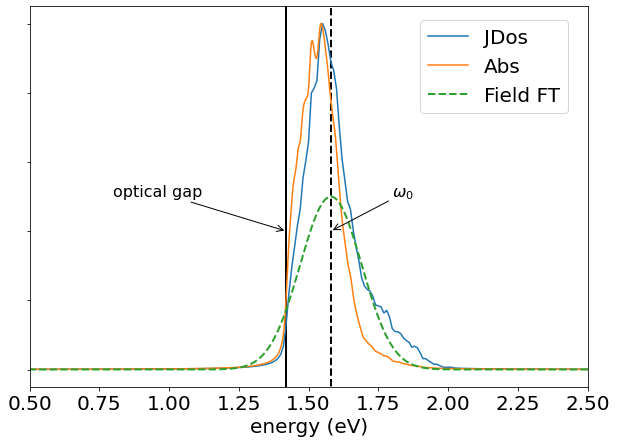

In [20]:
label_size = 20

fig, ax = plt.subplots(figsize=(10, 7))
dos.plot(plt,axes=ax,rescale=True)
ax.plot(eps_energy,eps_im/max(eps_im),label='Abs') #
ax.plot(ft_energy,0.5*(ft_abs/max(ft_abs))**2,label='Field FT',linestyle = '--',linewidth=2)
#ax.vlines(1.58,-1,30,linestyle='--',color='gray')
ax.set_ylim(-0.05,1.05)
ax.set_xlim(0.5,2.5) #6.5)
ax.set_xlabel('energy (eV)',size=label_size)
#ax.set_ylabel('JDOS',size=label_size)
ax.set_yticklabels([])
ax.vlines(x=1.42,ymin=-1,ymax=2,colors='black',linewidth=2)
ax.vlines(x=1.58,ymin=-1,ymax=2,colors='black',linewidth=2,linestyle='--')
ax.annotate('optical gap', xy=(1.42, 0.4), xytext=(0.8,0.5),size=16,arrowprops=dict(facecolor='black',arrowstyle='->'),)
ax.annotate('$\omega_0$', xy=(1.58, 0.4), xytext=(1.8,0.5),size=16,arrowprops=dict(facecolor='black',arrowstyle='->'),)
ax.tick_params(axis='both', which='major', labelsize=label_size)
ax.legend(loc=(0.7,0.72),fontsize=label_size,frameon=True)

#plt.savefig(fname='Plot/jdos_abs.eps',format='eps',bbox_inches = "tight")

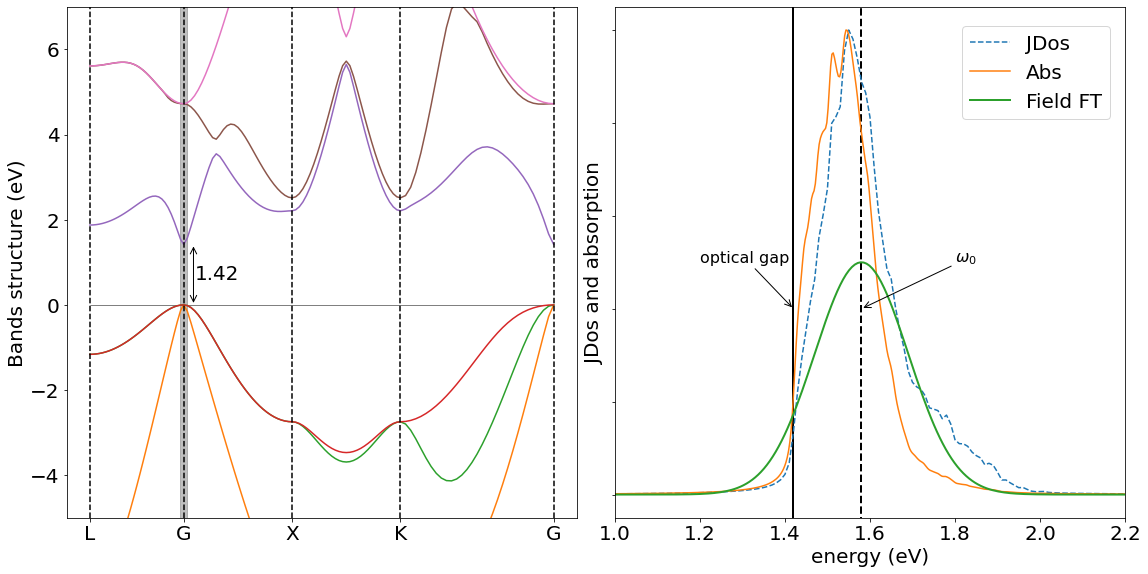

In [32]:
label_size = 20

#fig, ax0 = plt.subplots(figsize=(10, 16))
#gs = gridspec.GridSpec(2, 1, height_ratios=[1.2,1])
fig, ax0 = plt.subplots(figsize=(16, 8))
gs = gridspec.GridSpec(1, 2, width_ratios=[1,1])
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

ax0.set_ylim(-5,7)
bands.plot(plt,axes=ax0,selection=[i for i in range(0,7)])
ax0.annotate('', xy=(k0+0.09, 0), xytext=(k0+0.09, 1.42), arrowprops=dict(arrowstyle='<->'),size=16)
ax0.text(k0+0.1,0.6,'1.42',size=label_size)
ax0.axvspan(k0-kspan/2, k0+kspan/2, alpha=0.5, color='gray')
ax0.hlines(0.,0.,4.28,linestyles='-',color='gray',linewidth=1)
ax0.set_ylabel('Bands structure (eV)',size=label_size)
ax0.tick_params(axis='both', which='major', labelsize=label_size)

dos.plot(plt,axes=ax1,rescale=True,linestyle='--')
ax1.plot(eps_energy,eps_im/max(eps_im),label='Abs') #
ax1.plot(ft_energy,0.5*(ft_abs/max(ft_abs))**2,label='Field FT',linestyle = '-',linewidth=2)
#ax1.vlines(1.58,-1,30,linestyle='--',color='gray')
ax1.set_ylim(-0.05,1.05)
ax1.set_xlim(1.,2.2) #6.5)
ax1.set_xlabel('energy (eV)',size=label_size)
ax1.set_ylabel('JDos and absorption',size=label_size)
ax1.set_yticklabels([])
ax1.vlines(x=1.42,ymin=-1,ymax=2,colors='black',linewidth=2)
ax1.vlines(x=1.58,ymin=-1,ymax=2,colors='black',linewidth=2,linestyle='--')
ax1.annotate('optical gap', xy=(1.42, 0.4), xytext=(1.2,0.5),size=16,arrowprops=dict(facecolor='black',arrowstyle='->'),)
ax1.annotate('$\omega_0$', xy=(1.58, 0.4), xytext=(1.8,0.5),size=16,arrowprops=dict(facecolor='black',arrowstyle='->'),)
ax1.tick_params(axis='both', which='major', labelsize=label_size)
ax1.legend(loc=(0.68,0.78),fontsize=label_size,frameon=True)

plt.tight_layout(pad=0.8)
#plt.savefig(fname='Plot/bands_jdos_abs.eps',format='eps',bbox_inches = "tight")

## Comparison of the $P(\omega)$ in low and high field regimes

In [84]:
file_low = 'RT_Echo_k1000_kspan0.06/FixSymm/Results/echo_int_1e4_1e4_omega_1.58-fwhm_10.yaml'
file_high = 'RT_Echo_k1000_kspan0.06/FixSymm/Results/echo_int_1e7_1e7-bands_2-5_omega_1.58-fwhm_10.yaml'

In [85]:
with open(file_low, 'r') as f:
    data_low = yaml.safe_load(f)
with open(file_high, 'r') as f:
    data_high = yaml.safe_load(f)

In [88]:
data_low.keys()
time = data_low['time']
p_low = data_low['px_ref']
p_high = data_high['px_ref']

In [96]:
ft_low = T.eval_FT(time,p_low)
energy, p_low_ft = ft_low['energy'],ft_low['ft_abs']
ft_high = T.eval_FT(time,p_high)
p_high_ft = ft_high['ft_abs']

Time values expressed in fs. Energy array is provided in eV.
Maximum energy value = 20.668001033667718
Energy sampling step = 0.0068916308881853015
Time values expressed in fs. Energy array is provided in eV.
Maximum energy value = 20.668001033667718
Energy sampling step = 0.0068916308881853015


(0.0, 3.0)

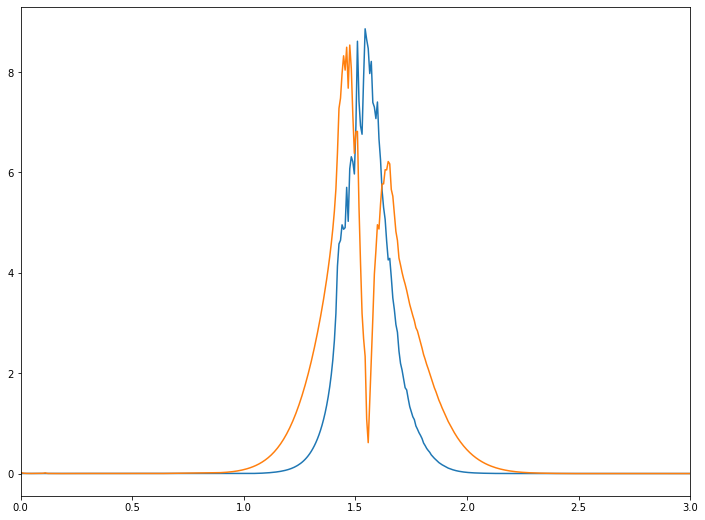

In [103]:
label_size = 20

fig, ax = plt.subplots(figsize=(12, 9))
ax.plot(energy,8*p_low_ft)
ax.plot(energy,p_high_ft)
ax.set_xlim(0.,3)

## Analysis of the echo peaks for low fields

We analyze the properties of the echo peaks in function of $\tau$.

This analysis is useful to assess the efficiency of the echo signal retrieval and to compare the numerical results with
the ones derived from the analytical perturbation theory

In [20]:
file = 'RT_Echo_k1000_kspan0.06/FixSymm/Results/echo_int_1e4_1e4_omega_1.58-fwhm_10.yaml'
run_dir = 'RT_Echo_k1000_kspan0.06/FixSymm'
outpath = 'RT_Echo_k1000_kspan0.06/FixSymm/100fs-direct-int_1e4_1e4-omega_1.58-fwhm_10/'
pulse_str = 'int_1e4_1e4-omega_1.58-fwhm-10'

#file = 'RT_Echo_k1000_kspan0.06/FixSymm/Results/echo_int_1e4_1e4-bands_2-5_omega_1.58-fwhm_10.yaml'
#file_pol = 'RT_Echo_k1000_kspan0.06/FixSymm/100fs-direct-int_1e4_1e4-bands_2-5-omega_1.58-fwhm_10/o-100fs-direct-int_1e4_1e4-bands_2-5-omega_1.58-fwhm_10.polarization'
#pulse_str = 'int_1e4_1e4-omega_1.58-fwhm-10-bands_2-5'

#eta = 4e-1
eta = 4e-3

In [21]:
with open(file, 'r') as f:
    data_loaded = yaml.safe_load(f)
data_loaded.keys()

dict_keys(['echo', 'profile', 'px_ref', 'time'])

In [22]:
results = P.YamboParser.from_path(run_dir,outpath)

Parse file RT_Echo_k1000_kspan0.06/FixSymm/100fs-direct-int_1e4_1e4-omega_1.58-fwhm_10/o-100fs-direct-int_1e4_1e4-omega_1.58-fwhm_10.polarization
Parse file RT_Echo_k1000_kspan0.06/FixSymm/100fs-direct-int_1e4_1e4-omega_1.58-fwhm_10/o-100fs-direct-int_1e4_1e4-omega_1.58-fwhm_10.current
Parse file RT_Echo_k1000_kspan0.06/FixSymm/100fs-direct-int_1e4_1e4-omega_1.58-fwhm_10/o-100fs-direct-int_1e4_1e4-omega_1.58-fwhm_10.external_field
Parse file RT_Echo_k1000_kspan0.06/FixSymm/100fs-direct-int_1e4_1e4-omega_1.58-fwhm_10/o-100fs-direct-int_1e4_1e4-omega_1.58-fwhm_10.carriers
Parse file : RT_Echo_k1000_kspan0.06/FixSymm/SAVE/ns.db1
Parse file : RT_Echo_k1000_kspan0.06/FixSymm/100fs-direct-int_1e4_1e4-omega_1.58-fwhm_10/ndb.dipoles
Spin dipoles not found in the ndb.dipoles
Parse file : RT_Echo_k1000_kspan0.06/FixSymm/100fs-direct-int_1e4_1e4-omega_1.58-fwhm_10/ndb.RT_G_PAR


In [23]:
polarization = results.data['polarization']
carriers = results.data['carriers']
field_ref = results.data['external_field']

We choose the values of $\tau$ reported in the plot and sorted in the correct order

In [24]:
#tau = ['0.5ps','1ps','1.5ps','2ps','2.5ps']
tau = ['50fs','100fs','150fs','200fs','250fs']

In [25]:
#time = 1e-3*np.array(data_loaded['time'])
time = np.array(data_loaded['time'])
px_ref = np.array(data_loaded['px_ref'])
profile_ref = field_ref['Profile']
echo = data_loaded['echo']
profile = data_loaded['profile']

for t in tau:
    echo[t] = np.array(echo[t])
    profile[t] = np.array(profile[t])

# we compute the maximum of the pulse signal, of the echo signals and of the profile
px_ref_max = max(px_ref)
echo_max = {}
for t in tau:
    echo_max[t] = max(echo[t])
profile_max = max(profile[tau[0]])

# we compute the value of the time at which there is the max of the pulse and echo signal and of the profile
indt0 = np.argmax(px_ref) 
tmax_px_ref = time[indt0] # tmax of the pulse signal
t0 = time[argrelextrema(profile[tau[0]],np.greater,order=2)[0][0]] # tmax of the pulse field
tmax_echo = {}
tmax_profile = {}
for t in tau:
    tmax_echo[t] = time[np.argmax(echo[t])]
    ind_max = argrelextrema(profile[t],np.greater,order=2)[0][1]
    tmax_profile[t] = time[ind_max]

In [26]:
t0,tmax_px_ref

(13.1, 19.8)

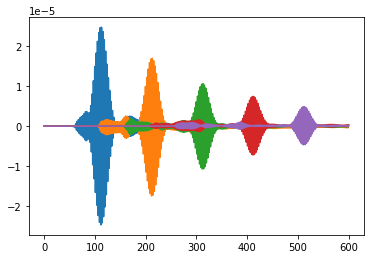

In [27]:
for t in tau:
    plt.plot(time,echo[t])

We build the expected exponential decay of the polarization, starting from the its peak

In [28]:
time_exp = time[indt0:]
exp_decay = px_ref_max*np.exp(-eta*(time_exp-time_exp[0]))

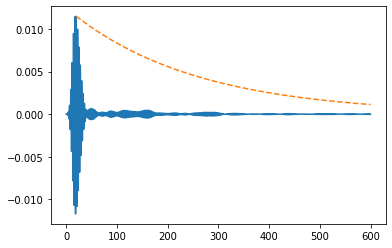

In [29]:
plt.plot(time,px_ref)
plt.plot(time_exp,exp_decay,linestyle='--')

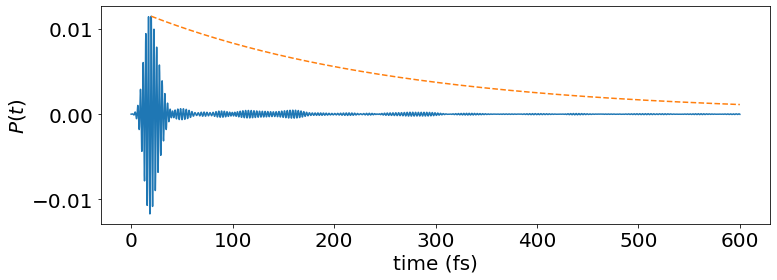

In [30]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(time,px_ref)
ax.plot(time_exp,exp_decay,linestyle='--')
#ax.set_xlim(0,400)
ax.set_xlabel('time (fs)',size=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_ylabel('$P(t)$',size=20)
#ax.set_yticks([])
plt.savefig(fname='Plot/polarization_decay.eps',format='eps',bbox_inches = "tight")

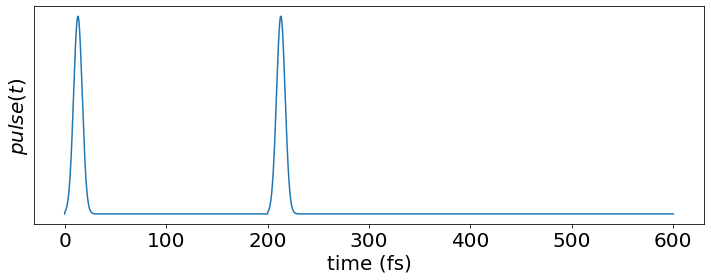

In [15]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(time,profile['200fs'])
ax.set_xlabel('time (fs)',size=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_ylabel('$P(t)$',size=20)
#ax.set_yticks([])
#plt.savefig(fname='Plot/polarization_decay.eps',format='eps',bbox_inches = "tight")'])
ax.set_xlabel('time (fs)',size=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_ylabel('$pulse(t)$',size=20)
ax.set_yticks([])
plt.savefig(fname='Plot/pulse_profile.eps',format='eps',bbox_inches = "tight")

We perform a gaussian fit of the first peak to estimate its properties

In [31]:
def gauss(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

In [32]:
ind_px_ref_env = argrelextrema(px_ref,np.greater,order=3)[0] 
time_env = time[ind_px_ref_env]
px_ref_env = px_ref[ind_px_ref_env]

(0.0, 100.0)

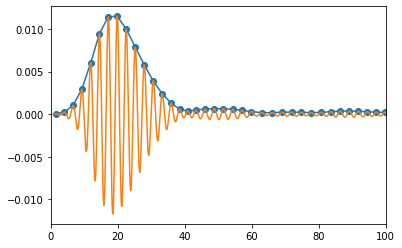

In [33]:
plt.plot(time_env,px_ref_env)
plt.scatter(time_env,px_ref_env)
plt.plot(time,px_ref)
#plt.xlim(0,0.5)
plt.xlim(0,100)

In [34]:
#sigma = 0.04
sigma = 10
p0 = [px_ref_max,t0,sigma]
gauss_pars_ref,pcov = curve_fit(gauss,time_env,px_ref_env,p0=p0)
gauss_pars_ref

array([1.15853473e-02, 1.97290669e+01, 6.84905823e+00])

(0.0, 100.0)

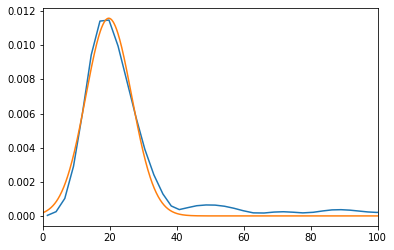

In [35]:
plt.plot(time_env,px_ref_env)
plt.plot(time,gauss(time,*gauss_pars_ref))
#plt.xlim(0,0.5)
plt.xlim(0,100)

The position of the peak and FWHM are given by

In [36]:
gauss_pars_ref[1],2*gauss_pars_ref[2]*np.sqrt(2*np.log(2))

(19.72906688393689, 16.128299617174314)

We define a procedure that perform a gaussian fit of the echo signal

In [37]:
gauss_pars = {}

for t in tau:
    signal = echo[t]
    # build the envelope of the signal
    ind_echo_env = argrelextrema(signal,np.greater,order=3)[0]
    values_env = signal[ind_echo_env]
    time_env_echo = time[ind_echo_env]
    # perform the fit
    #sigma = 0.100
    sigma = 80
    popt,pcov = curve_fit(gauss,time_env_echo,values_env,p0=[echo_max[t],tmax_echo[t],sigma])
    gauss_pars[t] = popt
gauss_pars

{'50fs': array([2.48888719e-05, 1.11933207e+02, 1.21498235e+01]),
 '100fs': array([1.72788885e-05, 2.12293300e+02, 1.17711290e+01]),
 '150fs': array([1.06154989e-05, 3.12703238e+02, 1.24549536e+01]),
 '200fs': array([7.46467275e-06, 4.11986657e+02, 1.27234636e+01]),
 '250fs': array([4.92797255e-06, 5.11943780e+02, 1.23350043e+01])}

We can compute the distance between the max of the profile of the echo peak and the position of the max (according to a gaussian fit)
of the echo pulse

In [38]:
for t in tau:
    diffe = gauss_pars[t][1]-t0
    print(t,diffe)

50fs 98.83320698769683
100fs 199.1933001939257
150fs 299.6032375059925
200fs 398.88665731410987
250fs 498.8437798682646


This computation shows that the echo peak is realized as expected and the shift w.r.t. the nominal time is due to the finite
size of the pulse

We compute the FWHM of the echo signal

In [7]:
20*np.sqrt(2*np.log(2))

23.548200450309494

In [39]:
for t in tau:
    fw = 2*gauss_pars[t][2]*np.sqrt(2*np.log(2))
    print(t,fw)

50fs 28.61064803594039
100fs 27.718890570704076
150fs 29.329174434609314
200fs 29.961467136966665
250fs 29.046715495012165


We evaluate the echo efficiency according to the formula
$$
\theta_e(t) = \theta_p\lambda e^{-\eta(t-t_0)}
$$
where $\lambda$ is the efficiency of the echo retrieval and $t_0$ is the time position of the pulse peak.
Here $\theta_p$ and $\theta_e$ represent the _intensity_ of the pulse and echo signals.

We compute these quantities according to the formula

In [40]:
theta_p = np.sqrt(simps(px_ref**2,time))
theta_e = [np.sqrt(simps(echo[t]**2,time)) for t in tau]

In this case we can also use the gaussian fit to estimate the areas

In [45]:
theta_p = np.sqrt(2*np.pi)*gauss_pars_ref[0]*gauss_pars_ref[2]
theta_e = [np.sqrt(2*np.pi)*gauss_pars[t][0]*gauss_pars[t][2] for t in tau]

and we perform an exponential fit using the expected decay time

In [46]:
def monoExp(t, A):
    return A*np.exp(-eta*(t-tmax_px_ref))

In [47]:
A0 = 1e-4 # start with values near those we expect
tvals = [tmax_echo[t] for t in tau]
params, cv = curve_fit(monoExp, tvals, theta_e, A0)
A = params[0]
A

0.0011007639393802158

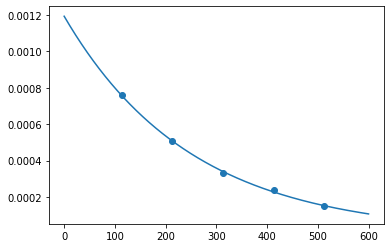

In [48]:
plt.scatter(tvals,theta_e)
plt.plot(time,monoExp(time,A))

The amplitude parameter $A$ is, by construction, the value of the signal at $t_0$, that
is at the time of the maximum of the pulse signal. From this parameter we can compute
the echo efficiency as

In [49]:
l = A/theta_p
l

0.005534320969781288

The two values are similar the general procedure can be used even when the signal has not a guassian shape.

Computation of the ratio of the amplitude of the pulse and echo signal (for $\tau=50$)

In [53]:
gauss_pars['50fs'][0]/gauss_pars_ref[0]

0.002148306066390905

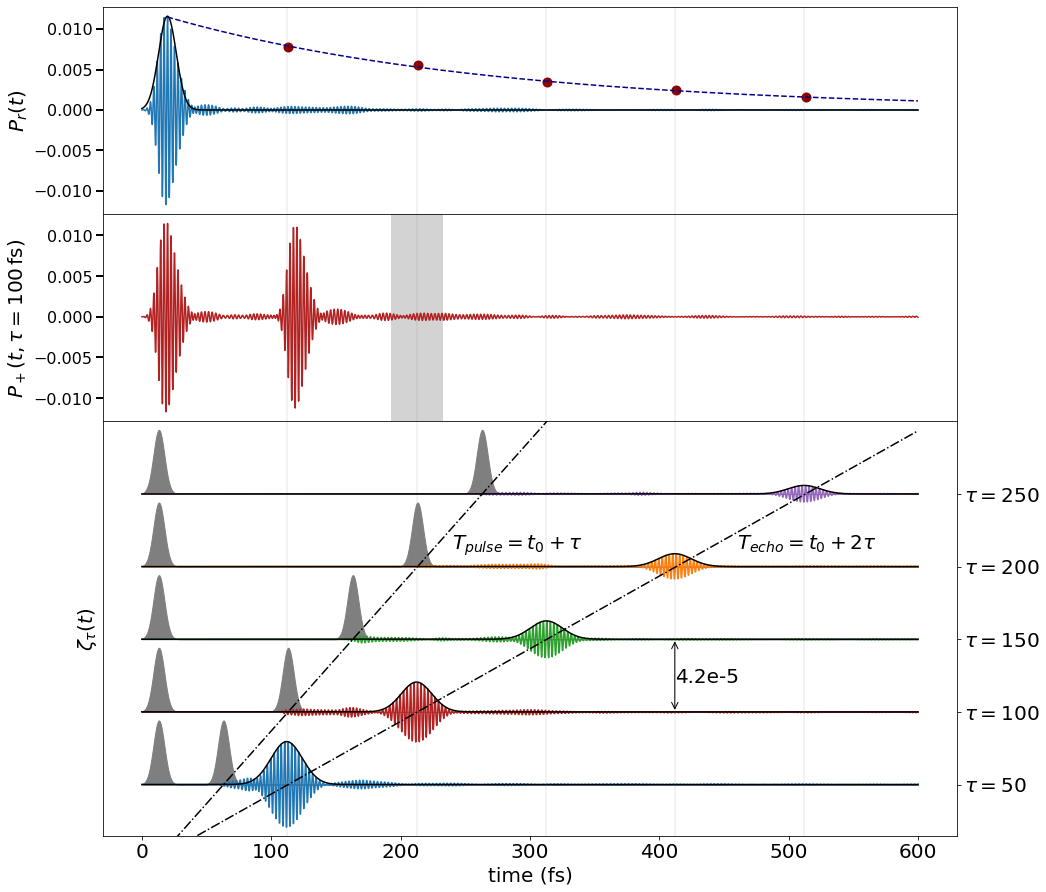

In [34]:
#tau_disp = [r'$\tau=0.5$',r'$\tau=1.0$',r'$\tau=1.5$',r'$\tau=2.0$',r'$\tau=2.5$']
tau_disp = [r'$\tau=50$',r'$\tau=100$',r'$\tau=150$',r'$\tau=200$',r'$\tau=250$']
label_size = 20
e_min = -1.2
e_max = 8.5
shift = 1.7
time_profile = np.array([tmax_profile[i] for i in tau])
time_echo = np.array([tmax_echo[t] for t in tau])
a_profile = 4*shift/(time_profile[-1]-time_profile[0])
b_profile = -a_profile*time_profile[0]
a_echo = 4*shift/(time_echo[-1]-time_echo[0])
b_echo = -a_echo*time_echo[0]
scatter_rescale = px_ref_max/A
ypos=0

fig, ax0 = plt.subplots(figsize=(14, 12))
gs = gridspec.GridSpec(3, 1, height_ratios=[1,1,2]) 
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])

# pr_ref panel
ax0.plot(time,px_ref)
#ax0.fill_between(time,profile_ref/max(profile_ref)*max(px_ref)-0.02,-0.02,color='tab:grey')
ax0.plot(time,gauss(time,*gauss_pars_ref),color='black',linestyle='-')
ax0.plot(time_exp,exp_decay,linestyle='--',color='darkblue')
ax0.scatter(time_echo,scatter_rescale*np.array(theta_e),linewidth=4,color='darkred')
for t in tau:
    ax0.axvline(gauss_pars[t][1],color='grey',linestyle='-',linewidth=0.2)
ax0.set_xticklabels([])
ax0.tick_params(width=2,length=7,labelsize=16)
ax0.tick_params(width=2,length=7)
ax0.set_ylabel('$P_r(t)$',size=label_size)

# polarization panel
ax1.plot(time,polarization['Pol_x'],color='firebrick')
#ax1.axvspan(gauss_pars['1ps'][1]-0.1, gauss_pars['1ps'][1]+0.1, color='lightgrey',fill=True)
ax1.axvspan(gauss_pars['100fs'][1]-20, gauss_pars['100fs'][1]+20, color='lightgrey',fill=True)
for t in tau:
    ax1.axvline(gauss_pars[t][1],color='grey',linestyle='-',linewidth=0.2)
ax1.set_xticklabels([])
ax1.tick_params(width=2,length=7,labelsize=16)
#ax1.set_ylabel('$P_+(t,\\tau=1)$',size=label_size)
ax1.set_ylabel('$P_+(t,\\tau=100 \, \\rm{fs})$',size=label_size)

# echo panel
#colors ={'0.5ps':'tab:blue','1ps':'firebrick','1.5ps':'tab:green','2ps':'tab:orange','2.5ps':'tab:purple'}
colors ={'50fs':'tab:blue','100fs':'firebrick','150fs':'tab:green','200fs':'tab:orange','250fs':'tab:purple'}
for t in tau:
    ax2.plot(time,ypos+echo[t]/echo_max[tau[0]],color=colors[t]) #,color='tab:orange'
    ax2.fill_between(time,ypos+1.5*profile[t]/profile_max,ypos,color='tab:grey')
    ax2.plot(time,ypos+gauss(time,*gauss_pars[t])/echo_max[tau[0]],color='black',linestyle='-')
    ax2.axvline(gauss_pars[t][1],color='grey',linestyle='-',linewidth=0.2)
    ypos+=shift
#arrow_x = 4.12
arrow_x = 412
arrow_y = 1.7
ax2.annotate('', xy=(arrow_x, arrow_y), xytext=(arrow_x, arrow_y+shift), arrowprops=dict(arrowstyle='<->'),size=16)
#ax2.text(arrow_x+0.1,arrow_y+shift/2.5,'1.6e-3',size=label_size)
ax2.text(arrow_x+0.1,arrow_y+shift/2.5,'4.2e-5',size=label_size)
ax2.plot(time,a_profile*time+b_profile,color='black',linestyle='-.')
ax2.plot(time,a_echo*time+b_echo,color='black',linestyle='-.')

#ax2.text(2.4,5.5,'$T_{pulse}=t_0+\\tau$',size=label_size)
#ax2.text(4.6,5.5,'$T_{echo}=t_0+2\\tau$',size=label_size)
ax2.text(240,5.5,'$T_{pulse}=t_0+\\tau$',size=label_size)
ax2.text(460,5.5,'$T_{echo}=t_0+2\\tau$',size=label_size)

#ax2.set_xlabel('time (ps)',size=label_size)
ax2.set_xlabel('time (fs)',size=label_size)
ax2.set_ylabel('$\zeta_{\\tau}(t)$',size=label_size)
ax2.set_ylim(e_min,e_max)
ax2.set_yticks([shift*i for i in range(len(tau_disp))])
ax2.set_yticklabels(tau_disp,size=label_size)
ax2.yaxis.tick_right()
ax2.tick_params(axis='both', which='major', labelsize=label_size)

plt.tight_layout(pad=-0.7)

#plt.savefig(fname='Plot/echo_analysis_%s.eps'%pulse_str,format='eps',bbox_inches = "tight")

In [66]:
t0

13.1

In [54]:
shift*echo_max[tau[0]]

4.210343249999998e-05

### Carriers and comparison with TLS results

We compute the ratio of volume of the actual sampling with the volume of the full brillouin zone 

In [40]:
from mppi.Utilities import Constants

In [41]:
bohr_cm = U.Constants.Bohr_radius*1e2
bohr_cm

5.291772e-09

In [42]:
sample_edge = 0.06
vol_direct = results.dft.eval_lattice_volume()*(bohr_cm**3)

vol_brillouin = results.dft.eval_reciprocal_lattice_volume(rescale=True)
vol_ratio = sample_edge**3/vol_brillouin 
vol_direct,vol_brillouin,vol_ratio

(4.3575414343056234e-23, 4.0, 5.399999999999999e-05)

In [43]:
TLS_file = 'TLS_Results/int_1e4-omega_1.58-fwhm_10.yaml'

In [44]:
with open(TLS_file, 'r') as f:
    data_tls = yaml.safe_load(f)
tls_time = np.array(data_tls['time'])
tls_carriers = np.array(data_tls['carriers'])
tls_px = np.array(data_tls['px'])
tls_echo = np.array(data_tls['echo'])

In [45]:
rescale = 2*34875/11895
rescale

5.863808322824716

In [46]:
carr = carriers['dne']
px = polarization['Pol_x']

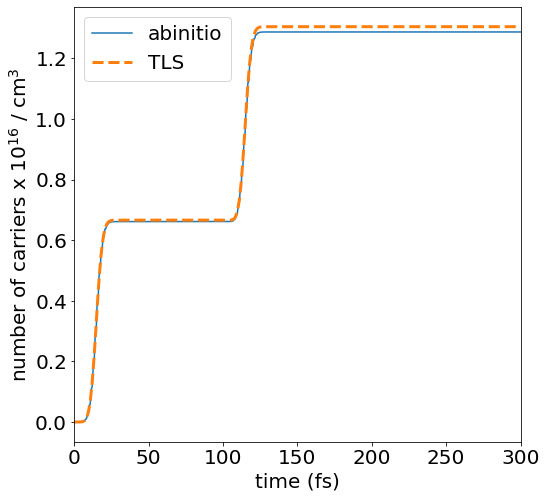

In [47]:
label_size = 20

fig,ax1 = plt.subplots(figsize=(8,8))
ax1.plot(time,vol_ratio*carr/vol_direct/1e16,label='abinitio')
ax1.plot(tls_time,vol_ratio*rescale*tls_carriers/vol_direct/1e16,linestyle='--',linewidth=3,label='TLS')
ax1.set_xlim(0,300)
ax1.set_xlabel('time (fs)',size=label_size)
ax1.set_ylabel('number of carriers x $10^{16}$ / cm$^3$',size=label_size)
ax1.tick_params(axis='both', which='major', labelsize=label_size)
ax1.legend(loc='best',fontsize=label_size,frameon=True)

#plt.savefig(fname='Plot/carriers_low_fields.eps',format='eps',bbox_inches = "tight")

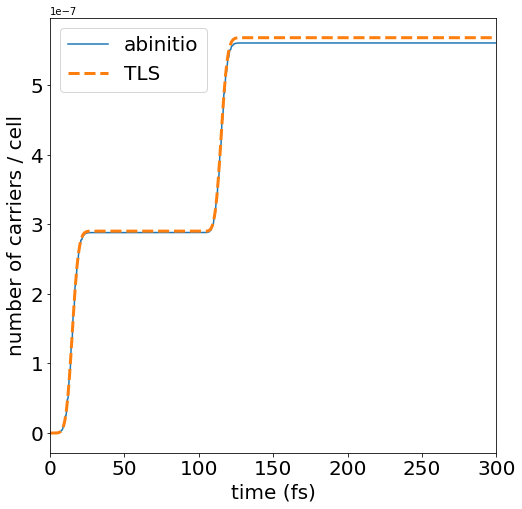

In [48]:
label_size = 20

fig,ax1 = plt.subplots(figsize=(8,8))
ax1.plot(time,vol_ratio*carr,label='abinitio')
ax1.plot(tls_time,vol_ratio*rescale*tls_carriers,linestyle='--',linewidth=3,label='TLS')
ax1.set_xlim(0,300)
ax1.set_xlabel('time (fs)',size=label_size)
ax1.set_ylabel('number of carriers / cell',size=label_size)
ax1.tick_params(axis='both', which='major', labelsize=label_size)
ax1.legend(loc='best',fontsize=label_size,frameon=True)

#plt.savefig(fname='Plot/carriers_low_fields.eps',format='eps',bbox_inches = "tight")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


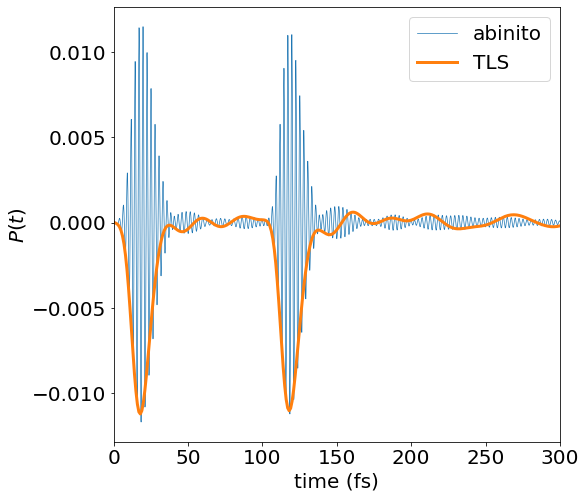

In [55]:
label_size = 20

fig,ax1 = plt.subplots(figsize=(8,8))
ax1.plot(time,px,label='abinito',linewidth=0.7)
ax1.plot(tls_time,rescale*tls_px,linewidth=3,label='TLS')
ax1.set_xlabel('time (fs)',size=label_size)
ax1.set_ylabel('$P(t)$',size=label_size)
ax1.tick_params(axis='both', which='major', labelsize=label_size)
ax1.set_xlim(0,300)
ax1.legend(loc='best',fontsize=label_size,frameon=True)

#plt.savefig(fname='Plot/polarization_low_fields_v2.eps',format='eps',bbox_inches = "tight")

## Analysis of the echo peaks for high fields

We analyze the results in the high field regime.

In particular we choose an intensity of $10^7$, so $10^3$ higher than the previous one.

In [4]:
file = 'RT_Echo_k1000_kspan0.06/FixSymm/Results/echo_int_1e7_1e7_omega_1.58-fwhm_10.yaml'
run_dir = 'RT_Echo_k1000_kspan0.06/FixSymm'
outpath = 'RT_Echo_k1000_kspan0.06/FixSymm/100fs-direct-int_1e7_1e7-omega_1.58-fwhm_10/'
ndb_car = 'RT_Echo_k1000_kspan0.06/FixSymm/100fs-direct-int_1e7_1e7-omega_1.58-fwhm_10/ndb.RT_carriers'
TLS_file = 'TLS_Results/int_1e7-omega_1.58-fwhm_10.yaml'
int_str = '1e7_1e7'

#file = 'RT_Echo_k1000_kspan0.06/FixSymm/Results/echo_int_1e7_1e7_omega_1.58-fwhm_10-tau_pulse_multiple.yaml'
#file_pol = 'RT_Echo_k1000_kspan0.06/FixSymm/100fs-direct-int_1e7_1e7-omega_1.58-fwhm_10-tau_pulse_multiple/o-100fs-direct-int_1e7_1e7-omega_1.58-fwhm_10-tau_pulse_multiple.polarization'
#file_car = 'RT_Echo_k1000_kspan0.06/FixSymm/100fs-direct-int_1e7_1e7-omega_1.58-fwhm_10-tau_pulse_multiple/o-100fs-direct-int_1e7_1e7-omega_1.58-fwhm_10-tau_pulse_multiple.carriers'
#ndb_car = 'RT_Echo_k1000_kspan0.06/FixSymm/100fs-direct-int_1e7_1e7-omega_1.58-fwhm_10-tau_pulse_multiple/ndb.RT_carriers'
#int_str = '1e7_1e7-tau_pulse_multiple'

#file = 'RT_Echo_k1000_kspan0.06/FixSymm/Results/echo_int_1e7_1e7-bands_2-5_omega_1.58-fwhm_10.yaml'
#run_dir = 'RT_Echo_k1000_kspan0.06/FixSymm'
#outpath = 'RT_Echo_k1000_kspan0.06/FixSymm/100fs-direct-int_1e7_1e7-bands_2-5-omega_1.58-fwhm_10/'
#ndb_car = 'RT_Echo_k1000_kspan0.06/FixSymm/100fs-direct-int_1e7_1e7-bands_2-5-omega_1.58-fwhm_10/ndb.RT_carriers'
#TLS_file = 'TLS_Results/int_1e7-omega_1.58-fwhm_10.yaml'
#int_str = '1e7_1e7-bands_2-5'

eta = 4e-3

In [5]:
with open(file, 'r') as f:
    data_loaded = yaml.safe_load(f)
data_loaded.keys()

dict_keys(['echo', 'profile', 'px_ref', 'time'])

In [6]:
results = P.YamboParser.from_path(run_dir,outpath)

Parse file RT_Echo_k1000_kspan0.06/FixSymm/100fs-direct-int_1e7_1e7-omega_1.58-fwhm_10/o-100fs-direct-int_1e7_1e7-omega_1.58-fwhm_10.external_field
Parse file RT_Echo_k1000_kspan0.06/FixSymm/100fs-direct-int_1e7_1e7-omega_1.58-fwhm_10/o-100fs-direct-int_1e7_1e7-omega_1.58-fwhm_10.polarization
Parse file RT_Echo_k1000_kspan0.06/FixSymm/100fs-direct-int_1e7_1e7-omega_1.58-fwhm_10/o-100fs-direct-int_1e7_1e7-omega_1.58-fwhm_10.carriers
Parse file RT_Echo_k1000_kspan0.06/FixSymm/100fs-direct-int_1e7_1e7-omega_1.58-fwhm_10/o-100fs-direct-int_1e7_1e7-omega_1.58-fwhm_10.current
Parse file : RT_Echo_k1000_kspan0.06/FixSymm/SAVE/ns.db1
Parse file : RT_Echo_k1000_kspan0.06/FixSymm/100fs-direct-int_1e7_1e7-omega_1.58-fwhm_10/ndb.dipoles
Spin dipoles not found in the ndb.dipoles
Parse file : RT_Echo_k1000_kspan0.06/FixSymm/100fs-direct-int_1e7_1e7-omega_1.58-fwhm_10/ndb.RT_G_PAR


In [7]:
polarization = results.data['polarization']
carriers = results.data['carriers']

In [8]:
with open(TLS_file, 'r') as f:
    data_tls = yaml.safe_load(f)
tls_time = np.array(data_tls['time'])
tls_carriers = np.array(data_tls['carriers'])
tls_px = np.array(data_tls['px'])
tls_echo = np.array(data_tls['echo'])

In [9]:
tls_rescale = 5.82

We choose the values of $\tau$ reported in the plot and sorted in the correct order

In [10]:
tau = ['50fs','100fs','150fs','200fs','250fs']
#tau = ['100fs']

In [11]:
time = np.array(data_loaded['time'])
px_ref_1e7 = np.array(data_loaded['px_ref'])
polx_1e7 = polarization['Pol_x']
echo = data_loaded['echo']
profile = data_loaded['profile']

for t in tau:
    echo[t] = np.array(echo[t])
    profile[t] = np.array(profile[t])
    
tmax_echo_1e7 = {}
for t in tau:
    tmax_echo_1e7[t] = time[np.argmax(echo[t])]
    
tmax_px_ref_1e7 = time[np.argmax(px_ref_1e7)]

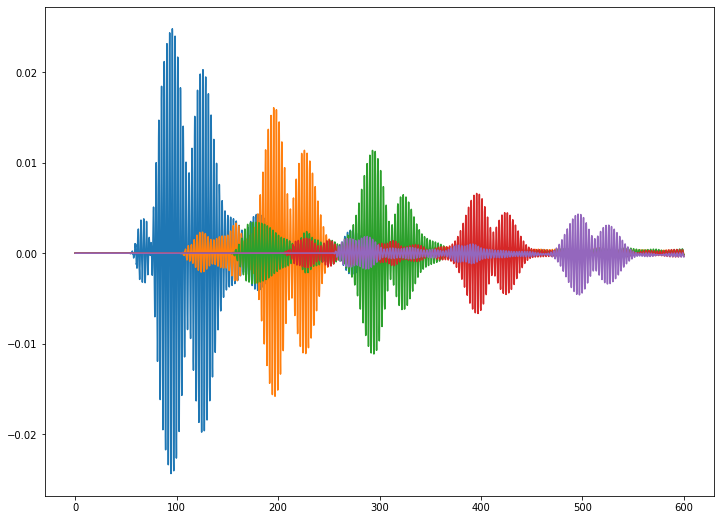

In [12]:
plt.figure(figsize=(12,9))
for t in tau:
    plt.plot(time,echo[t])

In this case it is interesting to investigate the shape of the signal peak after the first pulse and
the associated echo signal.

To this aim we analyze a single echo signal

In [13]:
t_sel = '100fs'
echo_1e7_sel = echo[t_sel]
profile_sel = profile[t_sel]

We build the envelope of the signals and we analyzed the position of the peaks. The field has peak at

In [14]:
ind_profile_max = argrelextrema(profile_sel,np.greater,order=3)[0] 
time_profile_max = time[ind_profile_max]
time_profile_max

array([ 13.1, 113.1])

In [15]:
ind_px_env = argrelextrema(polx_1e7,np.greater,order=3)[0] 
time_polx_1e7_env = time[ind_px_env]
polx_1e7_env = polx_1e7[ind_px_env]

In [16]:
ind_echo_env = argrelextrema(echo_1e7_sel,np.greater,order=3)[0] 
time_echo_1e7_env = time[ind_echo_env]
echo_1e7_env = echo_1e7_sel[ind_echo_env]

(0.0, 300.0)

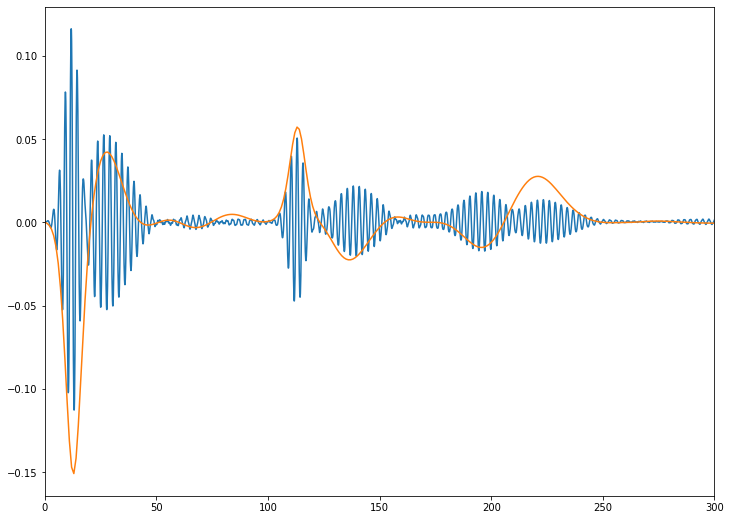

In [17]:
plt.figure(figsize=(12,9))
plt.plot(time,polx_1e7)
plt.plot(tls_time,tls_rescale*tls_px)
#plt.scatter(time_px_env,px_env,color='red')
#plt.plot(time_polx_1e7_env,polx_1e7_env,color='black')
plt.xlim(0,300)

Time position of the peak of the polarization

In [18]:
ind_px_max = argrelextrema(polx_1e7_env,np.greater,order=3)[0]
time_polx_1e7_env[ind_px_max]

array([ 11.8,  26.4,  66.4,  86.6, 113.1, 138.2, 195.8, 223.4, 266.9,
       297.5, 314.2, 328. , 363.4, 431.3, 459.4, 473.2, 501.4, 512. ,
       526. , 539.8, 570.5])

we observe the the signal after the first pulse is structured with a double peaks
located at 12 and 26 fs. The signal after the echo pulse has peaks located at
113 and 138 fs.

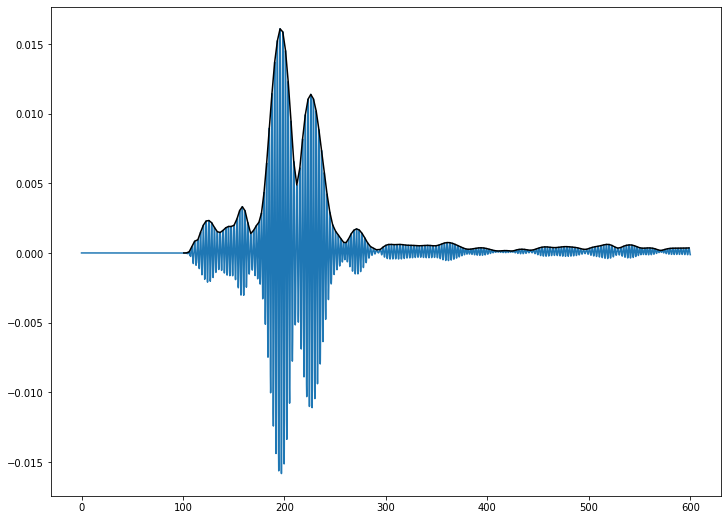

In [19]:
plt.figure(figsize=(12,9))
plt.plot(time,echo_1e7_sel)
#plt.scatter(time_echo_env,echo_env,color='red')
plt.plot(time_echo_1e7_env,echo_1e7_env,color='black')
#plt.xlim(0,400)

We perform the analysis of the time delay of the echo peaks....

Time position of the echo peaks

In [50]:
ind_echo_max = argrelextrema(echo_1e7_env,np.greater,order=4)[0]
time_echo_1e7_env[ind_echo_max]

array([125.6, 158.5, 195.7, 226. , 271.1, 305.5, 360.4, 393.9, 434.1,
       456.5, 478.4, 517.4, 539.8])

the echo peaks are located at 195 and 226

In [1]:
12+(112-12)*2

212

In [289]:
27+(112-27)*2

197

Comparison between the echo signal and the full polarization

In [ ]:
t_sel = '100fs'
echo_1e7_sel = echo[t_sel]

(-0.005, 0.04)

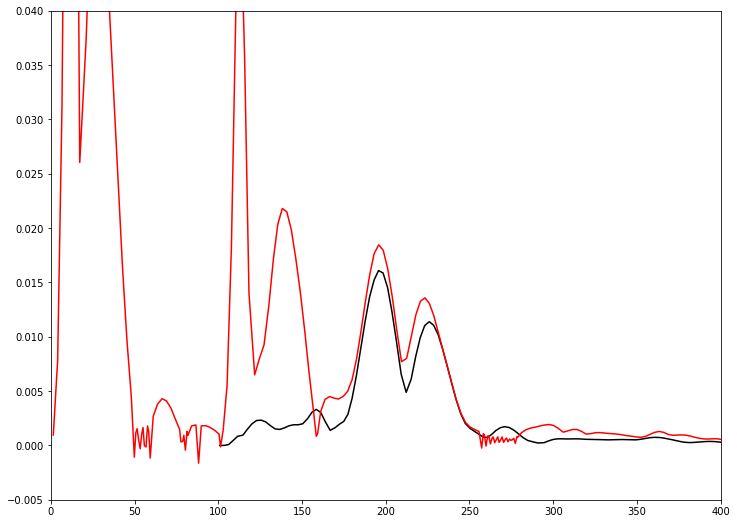

In [23]:
plt.figure(figsize=(12,9))
#plt.plot(time,echo_1e7_sel)
#plt.scatter(time_echo_env,echo_env,color='red')
plt.plot(time_echo_1e7_env,echo_1e7_env,color='black')
plt.plot(time_polx_1e7_env,polx_1e7_env,color='red')
plt.xlim(0,400)
plt.ylim(-0.005,0.04)

### Determination of the signal decay time

We estimante $T_2$ using the integral of the echo signal

In [65]:
tau

['50fs', '100fs', '150fs', '200fs', '250fs']

In [66]:
# using the time integral of the square of the signal
theta_p = np.sqrt(simps(px_ref_1e7**2,time))
theta_e = [np.sqrt(simps(echo[t]**2,time)) for t in tau]
theta_p,theta_e

(0.25050820857838285,
 [0.10116571263919831,
  0.06012280935318355,
  0.04330419018922022,
  0.026380382706041382,
  0.019199264605162206])

In [72]:
# using the maxima of the amplitudes
theta_p = max(px_ref_1e7)
theta_e = [max(echo[t]) for t in tau]
theta_p,theta_e

(0.11617171,
 [0.024822163969999998,
  0.01608723145,
  0.011365902669999999,
  0.0066078944599999995,
  0.004316484128])

and we perform an exponential fit using the expected decay time

In [73]:
def monoExp(t, A):
    return A*np.exp(-eta*(t-tmax_px_ref_1e7))

In [74]:
A0 = 0.1 # start with values near those we expect
#tvals = [tmax_echo_1e7[t] for t in tau]
tvals = [100,200,300,400,500]
params, cv = curve_fit(monoExp, tvals, theta_e, A0)
A = params[0]
A

0.03478341055433432

In [75]:
#A = 0.14

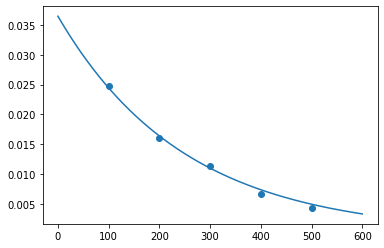

In [76]:
plt.scatter(tvals,theta_e)
plt.plot(time,monoExp(time,A))

We see that the integral of the signal scales as expected. The higher noise w.r.t the previous sampling is due to the higher non echo signal.

The amplitude parameter $A$ is, by construction, the value of the signal at $t_0$, that
is at the time of the maximum of the pulse signal. From this parameter we can compute
the echo efficiency as

In [77]:
l = A/theta_p
l

0.29941377771175376

efficiency of the amplitude

In [79]:
max(echo_1e7_env)/max(polx_1e7_env)*np.exp(eta*200)

0.30818856000403394

### FT of the px_ref signal

The maximum value of the energy in the  FT domain is given by 

In [164]:
dt = time[1]-time[0]
emax = h/(2*dt)
emax

20.678338479999997

In [165]:
dt = time[1]-time[0]
N = len(time)
freqs = np.fft.fftfreq(N,d=dt)
energies = h*freqs[0:int(N/2)]
pulseFT = np.fft.fft(px_ref_1e7)[0:int(N/2)]
px_ref_1e7_ft = np.sqrt(pulseFT.real**2+pulseFT.imag**2)

(0.0, 6.0)

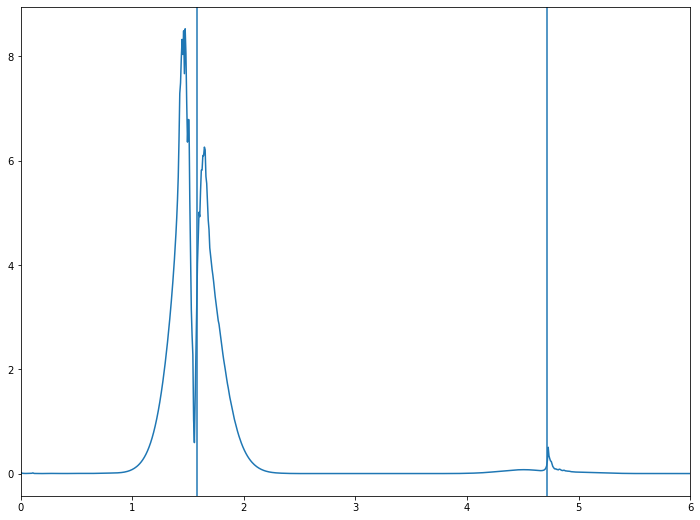

In [166]:
plt.figure(figsize=(12,9))
plt.plot(energies,px_ref_1e7_ft)
plt.axvline(1.58)
plt.axvline(4.72)
plt.xlim(0,6)

### FT of the echo signal

The maximum value of the energy in the  FT domain is given by 

In [167]:
dt = time[1]-time[0]
emax = h/(2*dt)
emax

20.678338479999997

In [168]:
dt = time[1]-time[0]
N = len(time)
freqs = np.fft.fftfreq(N,d=dt)
energies = h*freqs[0:int(N/2)]
pulseFT = np.fft.fft(echo_1e7_sel)[0:int(N/2)]
echo_1e7_sel_ft = np.sqrt(pulseFT.real**2+pulseFT.imag**2)
max_echo = max(echo_1e7_sel_ft)
echo_1e7_sel_ft /= max_echo

(0.0, 6.0)

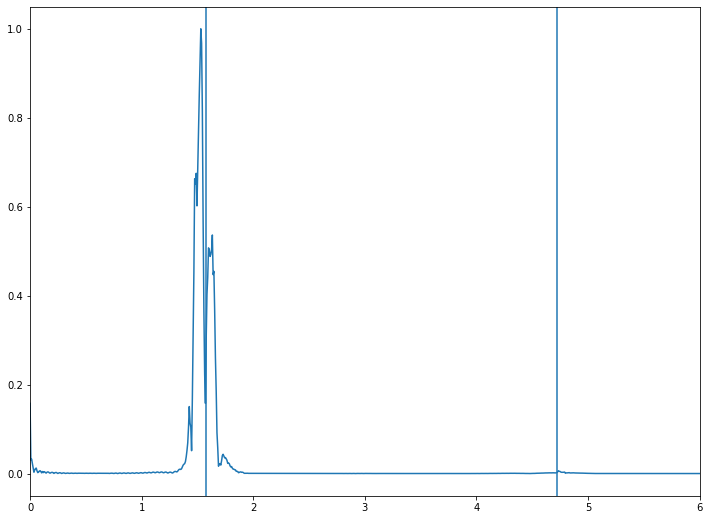

In [169]:
plt.figure(figsize=(12,9))
plt.plot(energies,echo_1e7_sel_ft)
plt.axvline(1.58)
plt.axvline(4.72)
plt.xlim(0,6)

We present data for the polarization and echo

In [ ]:
label_size = 20

fig, ax0 = plt.subplots(figsize=(14, 20))
#gs = gridspec.GridSpec(4, 1, height_ratios=[1,1,1.5,1])
gs = gridspec.GridSpec(4, 1, height_ratios=[1,1,1,1])
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
ax4 = plt.subplot(gs[3])

# polarization panel
ax0.plot(time,polx_1e7,label='abinitio')
ax0.plot(time_polx_1e7_env,polx_1e7_env,color='black')
ax0.plot(tls_time,tls_rescale*tls_px,linestyle='--',linewidth=3,label='TLS')
ax0.set_xlim(0.,300)
#ax0.set_yticklabels([])
ax0.tick_params(width=2,length=4,labelsize=16)
ax0.set_ylabel('$P_+(t,\\tau=100 \,\, \\rm{fs})$',size=label_size)
ax0.legend(loc=(0.8,0.1),fontsize=label_size,frameon=True)
ax0.set_xlabel('time (fs)',size=label_size)
ax0.set_title('panel a',fontsize=16,loc='left')

# echo panel
ax1.plot(time,echo_1e7_sel,label='abinitio')
ax1.plot(time_echo_1e7_env,echo_1e7_env,color='black')
ax1.plot(tls_time,tls_rescale*tls_echo,linestyle='--',linewidth=3,label='TLS')
ax1.set_xlim(100,350)
#ax1.set_yticklabels([])
ax1.tick_params(width=2,length=4,labelsize=16)
ax1.set_ylabel('$\zeta_{\\tau=100 \,\, \\rm{fs}}(t)$',size=label_size)
ax1.legend(loc=(0.8,0.6),fontsize=label_size,frameon=True)
ax1.set_xlabel('time (fs)',size=label_size)
ax1.set_title('panel b',fontsize=16,loc='left')

# echo ft panel
ax2.plot(energies,echo_1e7_sel_ft,linewidth=2,linestyle='-',label='Echo')
ax2.axvline(1.58,color='gray',linestyle='--',linewidth=2)
ax2.set_xlim(1.,2.2)
#ax2.set_yticklabels([])
#ax2.set_ylabel('Fourier analysis of $\zeta_\\tau(t)$',size=label_size)
ax2.set_ylabel('$\zeta_{\\tau=100 \,\, \\rm{fs}}(\omega)$',size=label_size)
ax2.set_xlabel('energy (eV)',size=label_size)
ax2.tick_params(width=2,length=4,labelsize=16)
#ax2.legend(loc=(0.02,0.7),fontsize=label_size,frameon=True)
#ax3 = plt.axes([0,0,1,1])
#ip = InsetPosition(ax2, [0.53,0.3,0.45,0.65])
#ax3.set_axes_locator(ip)
#ax3.plot(energies,echo_1e7_sel_ft,linewidth=2,linestyle='-',label='Echo')
#ax3.axvline(4.72,color='gray',linestyle='--',linewidth=2)
#ax3.set_xlim(3,6)
#ax3.set_ylim(-0.0025,0.01)
#ax3.set_yticklabels([])
#ax3.set_xlabel('energy (eV)',size=label_size)
#ax3.tick_params(labelsize=16)
ax2.set_title('panel c',fontsize=16,loc='left')

# echo intensity panel
ax4.scatter(tvals,theta_e,s=70,c='tab:red')
ax4.plot(time,monoExp(time,A),linestyle='--',linewidth=2)
ax4.set_xlabel('time (fs)',size=label_size)
ax4.tick_params(width=2,length=4,labelsize=16)
ax4.set_yticklabels([])
ax4.set_ylabel('Echo intensity (a.u.)',size=label_size)
ax4.set_title('panel d',fontsize=16,loc='left')
ax4.grid(linestyle='--',linewidth=0.3)

#plt.savefig(fname='Plot/echo_analysis-int_1e7_1e7-omega_1.58-fwhm_10.eps',format='eps',bbox_inches = "tight")

Plow without the FT

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


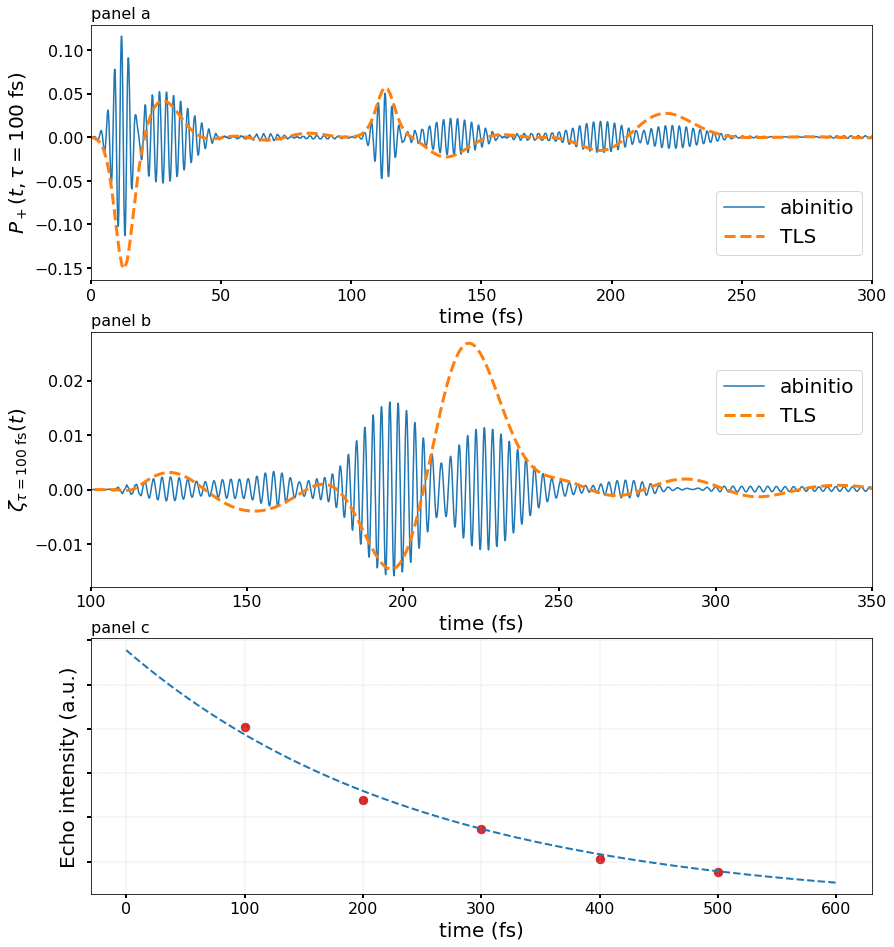

In [58]:
label_size = 20

fig, ax0 = plt.subplots(figsize=(14, 16))
gs = gridspec.GridSpec(3, 1, height_ratios=[1,1,1])
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])

# polarization panel
ax0.plot(time,polx_1e7,label='abinitio')
#ax0.plot(time_polx_1e7_env,polx_1e7_env,color='black')
ax0.plot(tls_time,tls_rescale*tls_px,linestyle='--',linewidth=3,label='TLS')
ax0.set_xlim(0.,300)
#ax0.set_yticklabels([])
ax0.tick_params(width=2,length=4,labelsize=16)
ax0.set_ylabel('$P_+(t,\\tau=100 \,\, \\rm{fs})$',size=label_size)
ax0.legend(loc=(0.8,0.1),fontsize=label_size,frameon=True)
ax0.set_xlabel('time (fs)',size=label_size)
ax0.set_title('panel a',fontsize=16,loc='left')

# echo panel
ax1.plot(time,echo_1e7_sel,label='abinitio')
#ax1.plot(time_echo_1e7_env,echo_1e7_env,color='black')
ax1.plot(tls_time,tls_rescale*tls_echo,linestyle='--',linewidth=3,label='TLS')
ax1.set_xlim(100,350)
#ax1.set_yticklabels([])
ax1.tick_params(width=2,length=4,labelsize=16)
ax1.set_ylabel('$\zeta_{\\tau=100 \,\, \\rm{fs}}(t)$',size=label_size)
ax1.legend(loc=(0.8,0.6),fontsize=label_size,frameon=True)
ax1.set_xlabel('time (fs)',size=label_size)
ax1.set_title('panel b',fontsize=16,loc='left')

# echo intensity panel
ax2.scatter(tvals,theta_e,s=70,c='tab:red')
ax2.plot(time,monoExp(time,A),linestyle='--',linewidth=2)
ax2.set_xlabel('time (fs)',size=label_size)
ax2.tick_params(width=2,length=4,labelsize=16)
ax2.set_yticklabels([])
ax2.set_ylabel('Echo intensity (a.u.)',size=label_size)
ax2.set_title('panel c',fontsize=16,loc='left')
ax2.grid(linestyle='--',linewidth=0.3)

#plt.savefig(fname='Plot/echo_analysis-int_1e7_1e7-omega_1.58-fwhm_10.eps',format='eps',bbox_inches = "tight")
#plt.savefig(fname='Plot/fig7.eps',format='eps',bbox_inches = "tight")

I analyze the FT of the echo signal in the TLS to see if the double peak emerge also there.

In [234]:
h_red = U.Constants.Planck_reduced_ev_ps*1e3 # hbar in eV*fs
energy = 1.58 # eV energy of the pulse
omega = energy/h_red # angular frequency of the pulse

In [235]:
tls_ft = U.Tools.eval_FT(tls_time,tls_rescale*tls_echo*np.cos(omega*tls_time))
tls_ft.keys()

Time values expressed in fs. Energy array is provided in eV.
Maximum energy value = 2.0472242083189367
Energy sampling step = 0.013739759787375414


dict_keys(['energy', 'ft_real', 'ft_im', 'ft_abs'])

In [236]:
energy_tls = tls_ft['energy']
echo_ft = tls_ft['ft_abs']

(0.0, 2.0)

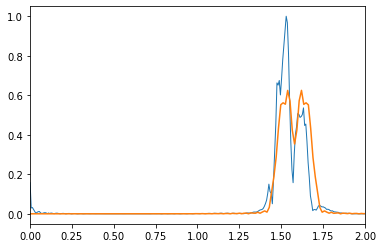

In [237]:
plt.plot(energies,echo_1e7_sel_ft,linewidth=1,linestyle='-',label='Echo')
plt.plot(energy_tls,2*echo_ft)
plt.xlim(0,2)

In [238]:
h_red*np.pi/25

0.08271335394464643

### Analysis of the carriers

We analyze the carriers and the non-equilibrium occupation level

In [239]:
bohr_cm = U.Constants.Bohr_radius*1e2
rescale = 2*34875/11895
bohr_cm,rescale

(5.291772e-09, 5.863808322824716)

In [240]:
sample_edge = 0.06
vol_direct = results.dft.eval_lattice_volume()*(bohr_cm**3)

vol_brillouin = results.dft.eval_reciprocal_lattice_volume(rescale=True)
vol_ratio = sample_edge**3/vol_brillouin 
vol_direct,vol_brillouin,vol_ratio

(4.3575414343056234e-23, 4.0, 5.399999999999999e-05)

In [241]:
output = P.YamboOutputParser([file_car])
carriers_1e7 = output['carriers']['dne']

Parse file RT_Echo_k1000_kspan0.06/FixSymm/100fs-direct-int_1e7_1e7-bands_2-5-omega_1.58-fwhm_10/o-100fs-direct-int_1e7_1e7-bands_2-5-omega_1.58-fwhm_10.carriers


We also plot the carriers

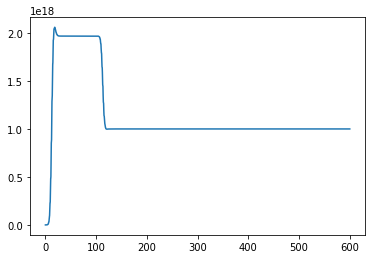

In [242]:
plt.plot(time,vol_ratio/vol_direct*carriers_1e7)

We analyze the RT_Carriers

In [197]:
occ = U.get_variable_from_db(ndb_car,'RT_carriers_delta_f')
ntime,nstates = occ.shape
ntime,nstates

(61, 83895)

In [198]:
time_ndb = np.linspace(0,600,ntime)

In [202]:
rt_bands = 7
#rt_bands = 4

In [203]:
def fetch_band_indexes(nstates,rt_bands,band):
    numk = int(nstates/rt_bands)
    indexes = [k*rt_bands+band for k in range(numk)]
    return indexes

In [205]:
v1_ind = fetch_band_indexes(nstates,rt_bands,0)
v2_ind = fetch_band_indexes(nstates,rt_bands,1)
v3_ind = fetch_band_indexes(nstates,rt_bands,2)

c1_ind = fetch_band_indexes(nstates,rt_bands,3)
c2_ind = fetch_band_indexes(nstates,rt_bands,4)
c3_ind = fetch_band_indexes(nstates,rt_bands,5)
c4_ind = fetch_band_indexes(nstates,rt_bands,6)

v1 = np.array(occ[:,v1_ind])
v2 = np.array(occ[:,v2_ind])
v3 = np.array(occ[:,v3_ind])

c1 = np.array(occ[:,c1_ind])
c2 = np.array(occ[:,c2_ind])
c3 = np.array(occ[:,c3_ind])
c4 = np.array(occ[:,c4_ind])

vtot = v1+v2+v3
ctot = c1+c2+c3+c4
ctot = c1

In [206]:
c1.shape,ctot.shape

((61, 11985), (61, 11985))

In [207]:
k_high_max = []
thrs = 1.9
for k in range(len(c1[0])):
    if max(ctot[:,k]) > thrs:
        k_high_max.append(k)
k_high_max = np.array(k_high_max)

In [208]:
k_high_max

array([    5,     8,    12, ..., 11937, 11949, 11961])

In [209]:
k_med = []
floor = 1
ceel = 1.1
for k in range(len(c1[0])):
    if max(ctot[:,k]) > floor and max(ctot[:,k]) < ceel:
        k_med.append(k)
k_med = np.array(k_med)

In [210]:
k_med

array([   13,   204,   221,   238,   272,   361,   440,   520,   568,
         671,   714,   871,   885,   996,  1061,  1062,  1067,  1068,
        1741,  1801,  1813,  2438,  2443,  2444,  2603,  2604,  2642,
        2647,  2648,  2846,  2851,  2852,  2885,  2892,  3260,  3473,
        3474,  3479,  3480,  3639,  3640,  3645,  3646,  4322,  4327,
        4328,  4517,  4518,  4523,  4524,  4541,  4542,  4547,  4548,
        5270,  5275,  5276,  5619,  5620,  5621,  5622,  5625,  5626,
        5627,  5628,  6125,  6126,  6131,  6132,  6230,  6235,  6236,
        6471,  6472,  6477,  6478,  6806,  6809,  6811,  6812,  6816,
        6986,  7202,  7207,  7331,  7332,  7337,  7338,  7369,  7370,
        7375,  7376,  7751,  7752,  7757,  7758,  8038,  8043,  8044,
        8149,  8150,  8155,  8156,  8554,  8559,  8560,  8987,  8994,
        9143,  9144,  9149,  9150,  9481,  9482,  9487,  9488,  9590,
        9595,  9875,  9876,  9881,  9882,  9995,  9997,  9998, 10002,
       10003, 10004,

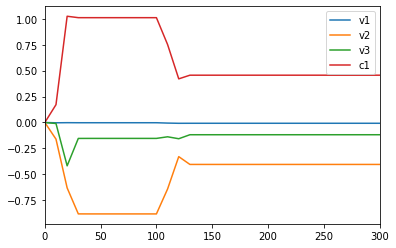

In [211]:
ksel = 13

plt.plot(time_ndb,v1[:,ksel],label='v1')
plt.plot(time_ndb,v2[:,ksel],label='v2')
plt.plot(time_ndb,v3[:,ksel],label='v3')
plt.plot(time_ndb,c1[:,ksel],label='c1')
plt.xlim(0,300)
plt.legend()


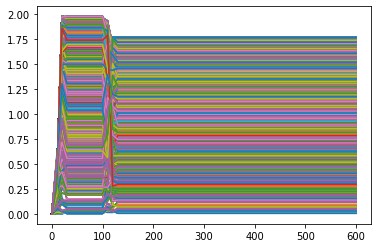

In [97]:
for k in range(len(c1[0])):
    plt.plot(time_ndb,c1[:,k])

IndexError: index 6848 is out of bounds for axis 1 with size 6848

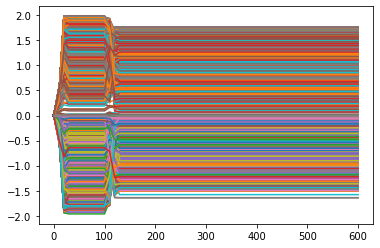

In [98]:
for k in range(len(c1[0])):
    plt.plot(time_ndb,c2[:,k])

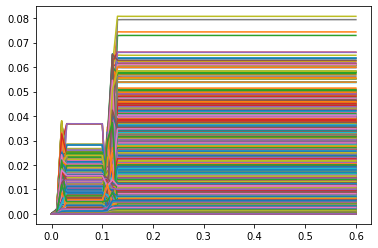

In [33]:
for k in range(len(c1[0])):
    plt.plot(time_ndb,c3[:,k])

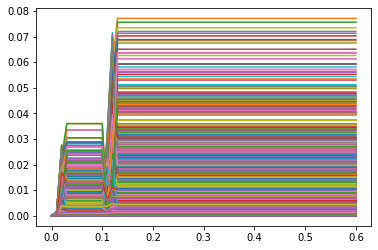

In [34]:
for k in range(len(c1[0])):
    plt.plot(time_ndb,c4[:,k])

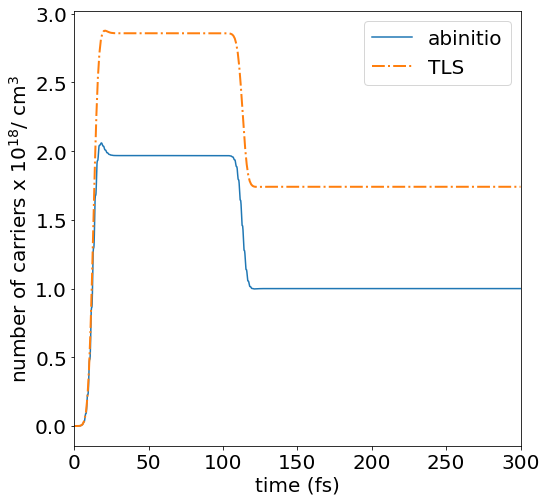

In [247]:
label_size = 20

fig,ax1 = plt.subplots(figsize=(8,8))
ax1.plot(time,vol_ratio/vol_direct*carriers_1e7/1e18,label='abinitio')
ax1.plot(tls_time,vol_ratio/vol_direct*1*rescale*tls_carriers/1e18,linestyle='-.',linewidth=2,label='TLS')
#ax1.plot(time_ndb,ctot[:,k_high_max[0]],linestyle='--',label='$k_1$')
#ax1.plot(time_ndb,ctot[:,13],linestyle='--',label='$k_2$')
ax1.set_xlim(0,300)
ax1.set_xlabel('time (fs)',size=label_size)
ax1.set_ylabel('number of carriers x $10^{18}$/ cm$^3$',size=label_size)
ax1.tick_params(axis='both', which='major', labelsize=label_size)
ax1.legend(loc='best',fontsize=label_size,frameon=True)

#plt.savefig(fname='Plot/carriers_high-fields.eps',format='eps',bbox_inches = "tight")

In [ ]:
################################################################à

## Polarization, echo peaks and carriers in the extended k region

In [70]:
#file = 'RT_Echo_k1000_kspan0.06/FixSymm/Results/echo_int_1e3_1e3_omega_1.58-fwhm_100.yaml'
#file_pol = 'RT_Echo_k1000_kspan0.06/FixSymm/2ps-direct-int_1e3_1e3-omega_1.58-fwhm_100/o-2ps-direct-int_1e3_1e3-omega_1.58-fwhm_100.polarization'
#file_car = 'RT_Echo_k1000_kspan0.06/FixSymm/2ps-direct-int_1e3_1e3-omega_1.58-fwhm_100/o-2ps-direct-int_1e3_1e3-omega_1.58-fwhm_100.carriers'
#ndb_car = 'RT_Echo_k1000_kspan0.06/FixSymm/2ps-direct-int_1e3_1e3-omega_1.58-fwhm_100/ndb.RT_carriers'
#int_str = '1e3_1e3'

file = 'RT_Echo_k1000_kspan0.06/FixSymm/Results/echo_int_1e5_1e5_omega_1.58-fwhm_100.yaml'
file_pol = 'RT_Echo_k1000_kspan0.06/FixSymm/1ps-direct-int_1e5_1e5-omega_1.58-fwhm_100/o-1ps-direct-int_1e5_1e5-omega_1.58-fwhm_100.polarization'
file_car = 'RT_Echo_k1000_kspan0.06/FixSymm/1ps-direct-int_1e5_1e5-omega_1.58-fwhm_100/o-1ps-direct-int_1e5_1e5-omega_1.58-fwhm_100.carriers'
ndb_car = 'RT_Echo_k1000_kspan0.06/FixSymm/1ps-direct-int_1e5_1e5-omega_1.58-fwhm_100/ndb.RT_carriers'
int_str = '1e5_1e5'

#file = 'RT_Echo_k1000_kspan0.06/FixSymm/Results/echo_int_1e5_1e5_omega_1.58-fwhm_10.yaml'
#file_pol = 'RT_Echo_k1000_kspan0.06/FixSymm/2ps-direct-int_1e5_1e5-omega_1.58-fwhm_10/o-2ps-direct-int_1e5_1e5-omega_1.58-fwhm_10.polarization'
#file_car = 'RT_Echo_k1000_kspan0.06/FixSymm/2ps-direct-int_1e5_1e5-omega_1.58-fwhm_10/o-2ps-direct-int_1e5_1e5-omega_1.58-fwhm_10.carriers'
#ndb_car = 'RT_Echo_k1000_kspan0.06/FixSymm/2ps-direct-int_1e5_1e5-omega_1.58-fwhm_10/ndb.RT_carriers'
#int_str = '1e5_1e5'

eta = 4e-1

In [71]:
with open(file, 'r') as f:
    data_loaded = yaml.safe_load(f)
data_loaded.keys()

dict_keys(['echo', 'profile', 'px_ref', 'time'])

In [72]:
polarization = P.YamboOutputParser([file_pol])['polarization']
polarization.keys()

Parse file RT_Echo_k1000_kspan0.06/FixSymm/1ps-direct-int_1e5_1e5-omega_1.58-fwhm_100/o-1ps-direct-int_1e5_1e5-omega_1.58-fwhm_100.polarization


dict_keys(['time', 'Pol_x', 'Pol_y', 'Pol_z'])

We choose the values of $\tau$ reported in the plot and sorted in the correct order

In [73]:
tau = ['0.5ps','1ps','1.5ps','2ps','2.5ps']

In [74]:
time = 1e-3*np.array(data_loaded['time'])
px_ref = np.array(data_loaded['px_ref'])
pol_x = polarization['Pol_x']
echo = data_loaded['echo']
profile = data_loaded['profile']

for t in tau:
    echo[t] = np.array(echo[t])
    profile[t] = np.array(profile[t])
    
tmax_echo = {}
for t in tau:
    tmax_echo[t] = time[np.argmax(echo[t])]
    
tmax_px_ref = time[np.argmax(px_ref)]

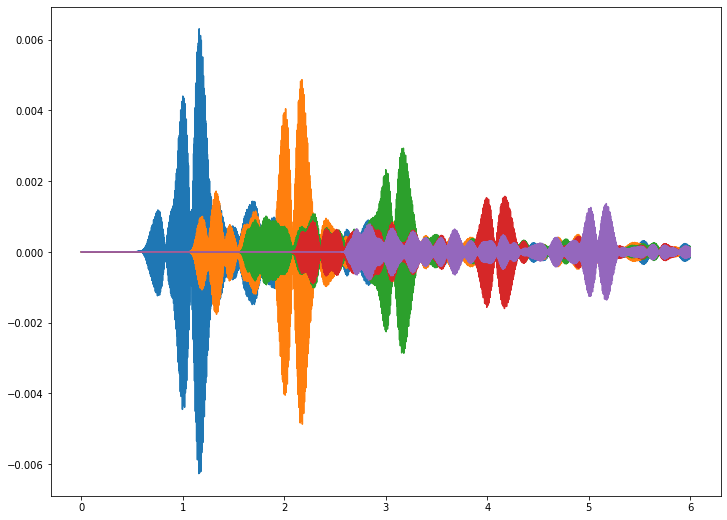

In [75]:
plt.figure(figsize=(12,9))
for t in tau:
    plt.plot(time,echo[t])

In this case it is interesting to investigate the shape of the signal peak after the first pulse and
the associated echo signal.

To this aim we analyze a single echo signal

In [76]:
t_sel = '1ps'
echo_sel = echo[t_sel]

We build the envelope of the signals

In [77]:
ind_px_env = argrelextrema(pol_x,np.greater,order=3)[0] 
time_px_env = time[ind_px_env]
px_env = pol_x[ind_px_env]

In [78]:
ind_echo_env = argrelextrema(echo_sel,np.greater,order=3)[0] 
time_echo_env = time[ind_echo_env]
echo_env = echo_sel[ind_echo_env]

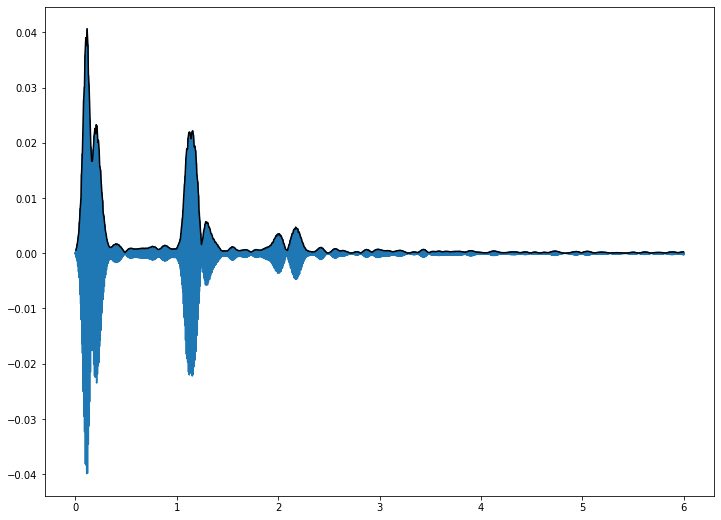

In [79]:
plt.figure(figsize=(12,9))
plt.plot(time,polarization['Pol_x'])
#plt.scatter(time_px_env,px_env,color='red')
plt.plot(time_px_env,px_env,color='black')
#plt.xlim(0,3)

(0.0, 4.0)

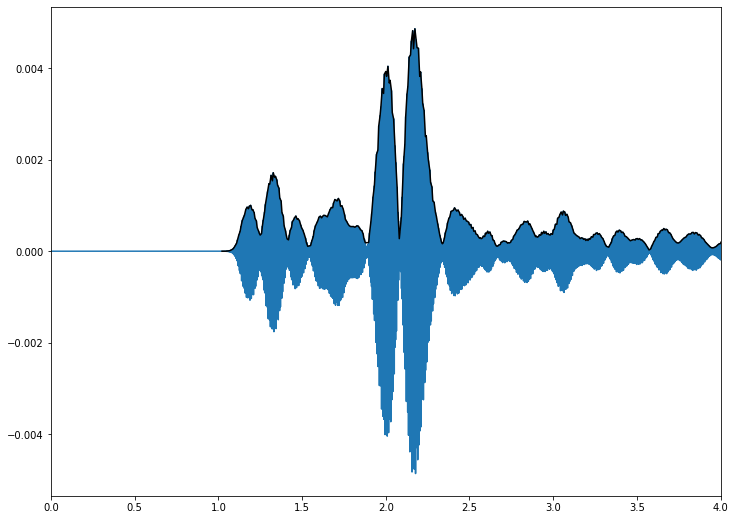

In [80]:
plt.figure(figsize=(12,9))
plt.plot(time,echo_sel)
#plt.scatter(time_echo_env,echo_env,color='red')
plt.plot(time_echo_env,echo_env,color='black')
plt.xlim(0,4)

We compute the time position of the various peaks

In [81]:
ind_px_max = argrelextrema(px_env,np.greater,order=4)[0]
time_px_env[ind_px_max]

array([0.118, 0.208, 0.4  , 0.553, 0.658, 0.766, 0.885, 1.158, 1.288,
       1.55 , 1.681, 1.782, 2.013, 2.174, 2.427, 2.56 , 2.643, 2.774,
       2.872, 2.978, 3.077, 3.203, 3.346, 3.429, 3.527, 3.589, 3.659,
       3.751, 3.785, 3.906, 4.132, 4.323, 4.437, 4.527, 4.633, 4.723,
       4.944, 5.055, 5.183, 5.344, 5.501, 5.62 , 5.75 , 5.893, 5.988])

we observe the the signal after the first pulse is structured with a double peaks
located at 118 and 208 fs. The signal after the echo pulse has peaks located at
1.158 and 1.288.

In [82]:
ind_echo_max = argrelextrema(echo_env,np.greater,order=4)[0]
time_echo_env[ind_echo_max]

array([1.193, 1.328, 1.463, 1.717, 1.828, 2.013, 2.174, 2.411, 2.609,
       2.702, 2.848, 2.944, 3.061, 3.263, 3.395, 3.503, 3.661, 3.838,
       4.046, 4.173, 4.263, 4.374, 4.462, 4.557, 4.702, 4.902, 5.037,
       5.159, 5.454, 5.639, 5.74 , 5.846])

the echo peaks are located at 2.013 and 2.174

In [83]:
0.208 + (1.127-0.208)*2

2.0460000000000003

In [84]:
0.118 + (1.127-0.118)*2

2.1359999999999997

### Determination of the signal decay time

We estimante $T_2$ using the integral of the echo signal

In [75]:
theta_p = np.sqrt(simps(px_ref**2,time))
theta_e = [np.sqrt(simps(echo[t]**2,time)) for t in tau]

and we perform an exponential fit using the expected decay time

In [76]:
def monoExp(t, A):
    return A*np.exp(-eta*(t-tmax_px_ref))

In [77]:
A0 = 1e-4 # start with values near those we expect
tvals = [tmax_echo[t] for t in tau]
params, cv = curve_fit(monoExp, tvals, theta_e, A0)
A = params[0]
A

0.003190484005510415

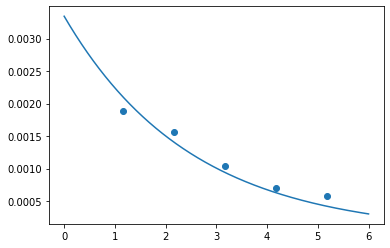

In [78]:
plt.scatter(tvals,theta_e)
plt.plot(time,monoExp(time,A))

We see that the integral of the signal scales as expected. The higher noise w.r.t the previous sampling is due to the higher non echo signal.

The amplitude parameter $A$ is, by construction, the value of the signal at $t_0$, that
is at the time of the maximum of the pulse signal. From this parameter we can compute
the echo efficiency as

In [79]:
l = A/theta_p
l

0.37768004173278963

### FT of the px_ref signal

The maximum value of the energy in the  FT domain is given by 

In [85]:
dt = time[1]-time[0]
emax = h/(2*dt)
emax

2.067833848

In [86]:
dt = time[1]-time[0]
N = len(time)
freqs = np.fft.fftfreq(N,d=dt)
energies = h*freqs[0:int(N/2)]
pulseFT = np.fft.fft(px_ref)[0:int(N/2)]
pulseFTmod = np.sqrt(pulseFT.real**2+pulseFT.imag**2)

(1.4, 1.8)

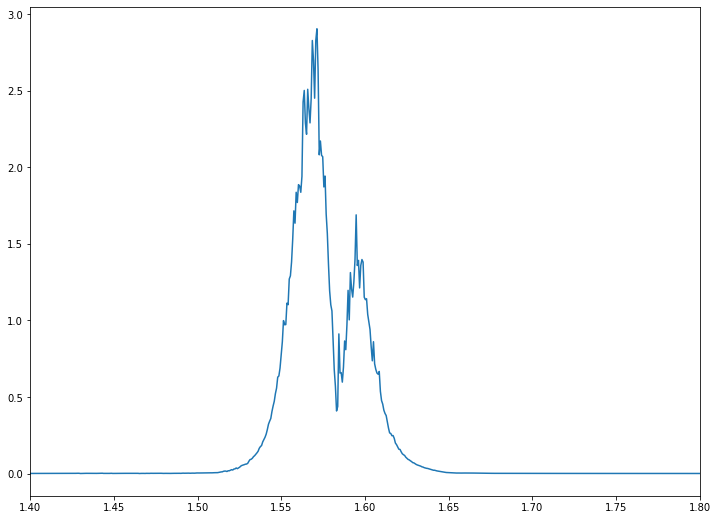

In [87]:
plt.figure(figsize=(12,9))
plt.plot(energies,pulseFTmod)
plt.xlim(1.4,1.8)

In [89]:
dt = time[1]-time[0]
N = len(time)
freqs = np.fft.fftfreq(N,d=dt)
energies = h*freqs[0:int(N/2)]
pulseFT = np.fft.fft(echo_sel)[0:int(N/2)]
pulseFTmod = np.sqrt(pulseFT.real**2+pulseFT.imag**2)

(1.4, 1.8)

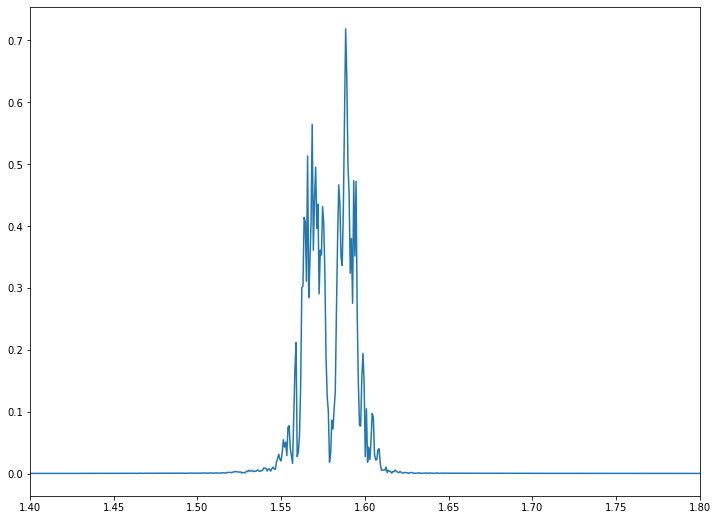

In [90]:
plt.figure(figsize=(12,9))
plt.plot(energies,pulseFTmod)
plt.xlim(1.4,1.8)

In [91]:
energies[argrelextrema(pulseFTmod,np.greater,order=4)[0]]

array([0.05444388, 0.05857886, 0.06271384, 0.07511878, 0.07994292,
       0.0840779 , 0.0895912 , 0.1026853 , 0.10613112, 0.11026609,
       0.11715773, 0.1212927 , 0.12473852, 0.13369764, 0.14403509,
       0.15161588, 0.15575086, 0.16195333, 0.16953412, 0.17297994,
       0.17642575, 0.17987157, 0.18331738, 0.19020901, 0.19434399,
       0.19778981, 0.20123562, 0.20468144, 0.20812725, 0.21226223,
       0.21570805, 0.21915386, 0.22328884, 0.22673466, 0.23018047,
       0.23362629, 0.23776127, 0.24120708, 0.24534206, 0.24878788,
       0.25499034, 0.25843616, 0.26257114, 0.26670612, 0.27084109,
       0.27566524, 0.27980021, 0.28393519, 0.28738101, 0.29082682,
       0.2949618 , 0.29840762, 0.30185343, 0.30598841, 0.30943423,
       0.31288004, 0.31701502, 0.32115   , 0.32528498, 0.32873079,
       0.33286577, 0.33631159, 0.3397574 , 0.34389238, 0.3473382 ,
       0.35078401, 0.35491899, 0.35836481, 0.36181062, 0.3659456 ,
       0.36939142, 0.37283723, 0.37628305, 0.37972886, 0.38317

### Analysis of the carriers

We analyze the carriers and the non-equilibrium occupation level

In [83]:
output = P.YamboOutputParser([file_car])
carriers = output['carriers']['dne']

Parse file RT_Echo_k1000_kspan0.06/FixSymm/1ps-direct-int_1e5_1e5-omega_1.58-fwhm_100/o-1ps-direct-int_1e5_1e5-omega_1.58-fwhm_100.carriers


We also plot the carriers

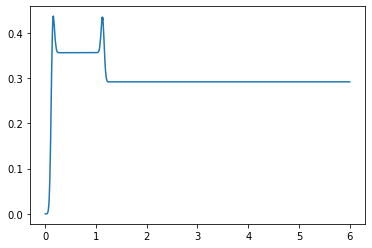

In [84]:
plt.plot(time,carriers)

We analyze the RT_Carriers

In [203]:
occ = U.get_variable_from_db(ndb_car,'RT_carriers_delta_f')
ntime,nstates = occ.shape
ntime,nstates

(121, 83895)

In [204]:
time_ndb = np.linspace(0,6,ntime)

In [205]:
rt_bands = 7

In [206]:
def fetch_band_indexes(nstates,rt_bands,band):
    numk = int(nstates/rt_bands)
    indexes = [k*rt_bands+band for k in range(numk)]
    return indexes

In [207]:
c1_ind = fetch_band_indexes(nstates,rt_bands,3)
c2_ind = fetch_band_indexes(nstates,rt_bands,4)
c3_ind = fetch_band_indexes(nstates,rt_bands,5)
c4_ind = fetch_band_indexes(nstates,rt_bands,6)


c1 = occ[:,c1_ind]
c2 = occ[:,c2_ind]
c3 = occ[:,c3_ind]
c4 = occ[:,c4_ind]

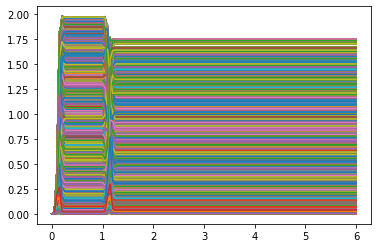

In [208]:
for k in range(len(c1[0])):
    plt.plot(time_ndb,c1[:,k])

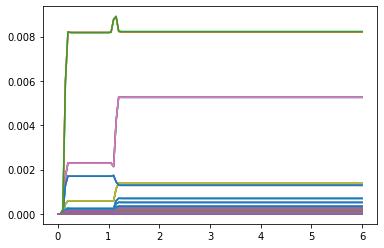

In [209]:
for k in range(len(c1[0])):
    plt.plot(time_ndb,c2[:,k])

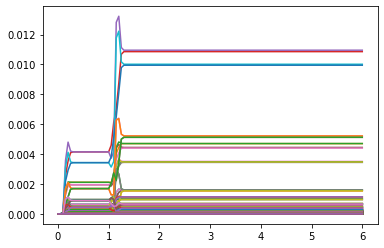

In [210]:
for k in range(len(c1[0])):
    plt.plot(time_ndb,c3[:,k])

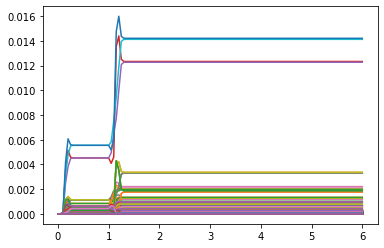

In [211]:
for k in range(len(c1[0])):
    plt.plot(time_ndb,c4[:,k])

## Polarization, echo peaks and carriers in the extended k region for short pulses

In [67]:
file = 'RT_Echo_k1000_kspan0.06/FixSymm/Results/echo_int_1e6_1e6_omega_1.58-fwhm_10.yaml'
file_pol = 'RT_Echo_k1000_kspan0.06/FixSymm/100fs-direct-int_1e6_1e6-omega_1.58-fwhm_10/o-100fs-direct-int_1e6_1e6-omega_1.58-fwhm_10.polarization'
file_car = 'RT_Echo_k1000_kspan0.06/FixSymm/100fs-direct-int_1e6_1e6-omega_1.58-fwhm_10/o-100fs-direct-int_1e6_1e6-omega_1.58-fwhm_10.carriers'
ndb_car = 'RT_Echo_k1000_kspan0.06/FixSymm/100fs-direct-int_1e6_1e6-omega_1.58-fwhm_10/ndb.RT_carriers'
int_str = '1e6_1e6'

eta = 4e-3

In [68]:
with open(file, 'r') as f:
    data_loaded = yaml.safe_load(f)
data_loaded.keys()

dict_keys(['echo', 'profile', 'px_ref', 'time'])

In [69]:
polarization = P.YamboOutputParser([file_pol])['polarization']
polarization.keys()

Parse file RT_Echo_k1000_kspan0.06/FixSymm/100fs-direct-int_1e6_1e6-omega_1.58-fwhm_10/o-100fs-direct-int_1e6_1e6-omega_1.58-fwhm_10.polarization


dict_keys(['time', 'Pol_x', 'Pol_y', 'Pol_z'])

We choose the values of $\tau$ reported in the plot and sorted in the correct order

In [70]:
tau = ['50fs','100fs','150fs','200fs','250fs']

In [71]:
time = np.array(data_loaded['time'])
px_ref_1e6 = np.array(data_loaded['px_ref'])
echo = data_loaded['echo']
profile = data_loaded['profile']
polx_1e6 = polarization['Pol_x']


for t in tau:
    echo[t] = np.array(echo[t])
    profile[t] = np.array(profile[t])

# we compute the maximum of the pulse signal, of the echo signals and of the profile
px_ref_1e6_max = max(px_ref_1e6)
echo_max = {}
for t in tau:
    echo_max[t] = max(echo[t])
profile_max = max(profile[tau[0]])

# we compute the value of the time at which there is the max of the pulse and echo signal and of the profile
#indt0 = np.argmax(px_ref) 
tmax_px_ref_1e6 = time[np.argmax(px_ref_1e6)] # tmax of the pulse signal
t0 = time[argrelextrema(profile[tau[0]],np.greater,order=2)[0][0]] # tmax of the pulse field
tmax_echo = {}
tmax_profile = {}
for t in tau:
    tmax_echo[t] = time[np.argmax(echo[t])]
    #ind_max = 
    tmax_profile[t] = time[argrelextrema(profile[t],np.greater,order=2)[0][1]]

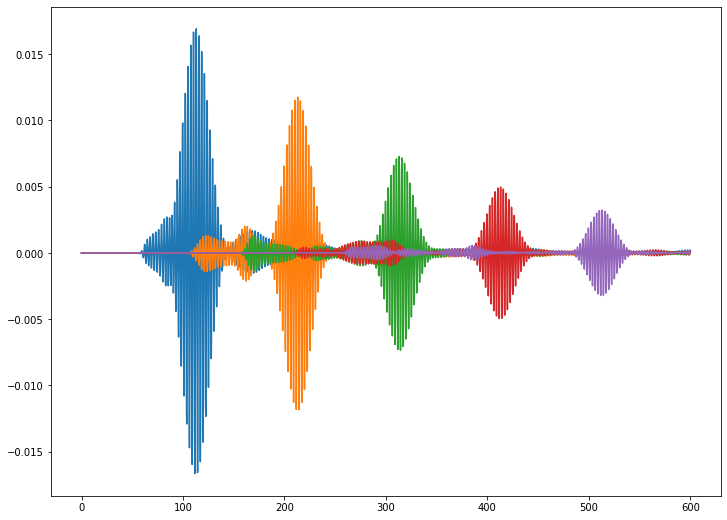

In [72]:
plt.figure(figsize=(12,9))
for t in tau:
    plt.plot(time,echo[t])

We perform a gaussian fit of the first peak to estimate its properties

In [73]:
def gauss(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

In [74]:
ind_px_ref_env = argrelextrema(px_ref_1e6,np.greater,order=3)[0] 
time_env = time[ind_px_ref_env]
px_ref_1e6_env = px_ref_1e6[ind_px_ref_env]

(0.0, 100.0)

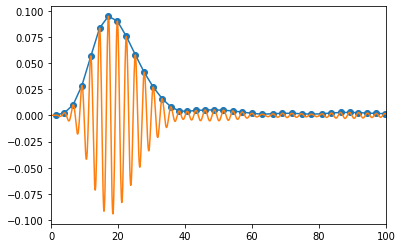

In [75]:
plt.plot(time_env,px_ref_1e6_env)
plt.scatter(time_env,px_ref_1e6_env)
plt.plot(time,px_ref_1e6)
plt.xlim(0,100)

In [79]:
sigma = 4
p0 = [px_ref_1e6_max,t0,sigma]
gauss_pars_ref,pcov = curve_fit(gauss,time_env,px_ref_1e6_env,p0=p0)
gauss_pars_ref

array([ 0.09420844, 18.91385251,  6.71787993])

(0.0, 100.0)

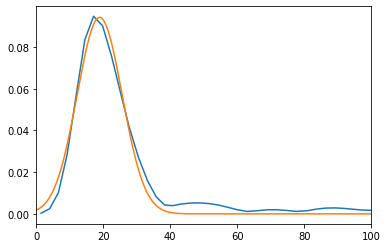

In [81]:
plt.plot(time_env,px_ref_1e6_env)
plt.plot(time,gauss(time,*gauss_pars_ref))
plt.xlim(0,100)

The width of the peak is about 6.7 fs, so is larger than the one of the pulse (around 4.2 fs) and the maximum is located at 19 fs, that is
around 6 fs after the peak of the profile (there is more delay compared with the long pulse in the low energy regime).

We define a procedure that perform a gaussian fit of the echo signal

In [82]:
gauss_pars = {}

for t in tau:
    signal = echo[t]
    # build the envelope of the signal
    ind_echo_env = argrelextrema(signal,np.greater,order=3)[0]
    values_env = signal[ind_echo_env]
    time_env = time[ind_echo_env]
    # perform the fit
    sigma = 10
    popt,pcov = curve_fit(gauss,time_env,values_env,p0=[echo_max[t],tmax_echo[t],sigma])
    gauss_pars[t] = popt
gauss_pars

{'50fs': array([1.67969217e-02, 1.12543244e+02, 1.27051787e+01]),
 '100fs': array([1.18736781e-02, 2.13000220e+02, 1.21069251e+01]),
 '150fs': array([7.27170194e-03, 3.13658111e+02, 1.26678365e+01]),
 '200fs': array([4.97258334e-03, 4.12909777e+02, 1.27869485e+01]),
 '250fs': array([3.26527553e-03, 5.12664563e+02, 1.22536989e+01])}

The echo peaks are very large if compared with the width of the pulse. The are around 12 fs, while the pulse
width is around 4 fs. In the low field regime, the echo peaks have a width around twice the pulse one. 

We can compute the distance between the max of the profile of the echo peak and the position of the max (according to a gaussian fit)
of the echo pulse

In [83]:
for t in tau:
    diffe = gauss_pars[t][1]-t0
    print(t,diffe)

50fs 99.44324370559276
100fs 199.90022025804387
150fs 300.55811075328126
200fs 399.80977653721874
250fs 499.5645631167479


This computation shows that the echo peak is realized as expected and the shift w.r.t. the nominal time is due to the finite
size of the pulse

In this case it is interesting to investigate the shape of the signal peak after the first pulse and
the associated echo signal.

To this aim we analyze a single echo signal

In [84]:
t_sel = '100fs'
echo_1e6_sel = echo[t_sel]

We build the envelope of the signals

In [85]:
ind_px_env = argrelextrema(polx_1e6,np.greater,order=3)[0] 
time_polx_1e6_env = time[ind_px_env]
polx_1e6_env = polx_1e6[ind_px_env]

In [86]:
ind_echo_env = argrelextrema(echo_1e6_sel,np.greater,order=3)[0] 
time_echo_1e6_env = time[ind_echo_env]
echo_1e6_env = echo_1e6_sel[ind_echo_env]

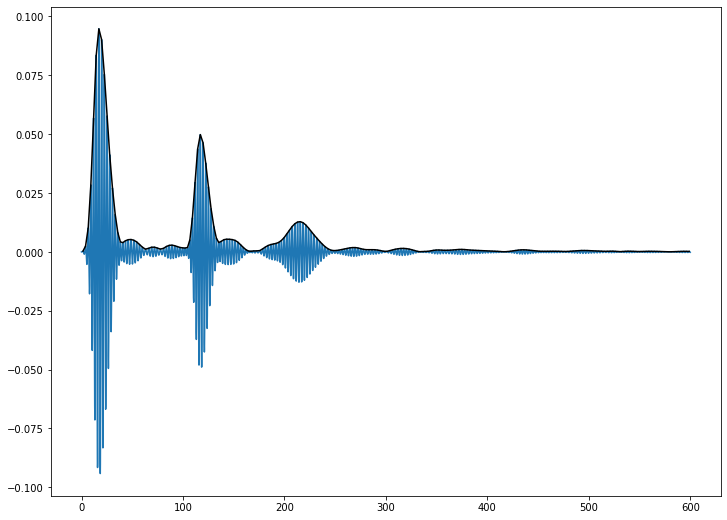

In [87]:
plt.figure(figsize=(12,9))
plt.plot(time,polx_1e6)
plt.plot(time_polx_1e6_env,polx_1e6_env,color='black')
#plt.xlim(0,300)

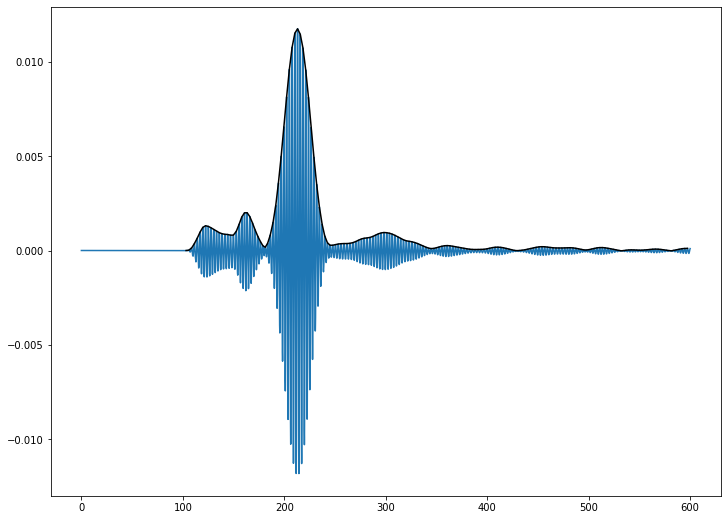

In [88]:
plt.figure(figsize=(12,9))
plt.plot(time,echo_1e6_sel)
#plt.scatter(time_echo_env,echo_env,color='red')
plt.plot(time_echo_1e6_env,echo_1e6_env,color='black')
#plt.xlim(0,400)

### Determination of the signal decay time

We estimante $T_2$ using the integral of the echo signal

In [89]:
theta_p = np.sqrt(simps(px_ref_1e6**2,time))
theta_e = [np.sqrt(simps(echo[t]**2,time)) for t in tau]

and we perform an exponential fit using the expected decay time

In [90]:
def monoExp(t, A):
    return A*np.exp(-eta*(t-tmax_px_ref_1e6))

In [91]:
A0 = 1e-4 # start with values near those we expect
tvals = [tmax_echo[t] for t in tau]
params, cv = curve_fit(monoExp, tvals, theta_e, A0)
A = params[0]
A

0.08436326796756978

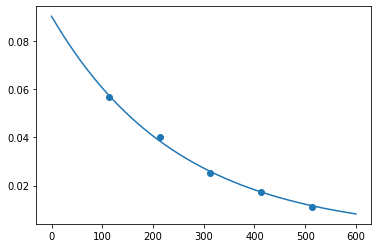

In [92]:
plt.scatter(tvals,theta_e)
plt.plot(time,monoExp(time,A))

We see that the integral of the signal scales as expected. The higher noise w.r.t the previous sampling is due to the higher non echo signal.

The amplitude parameter $A$ is, by construction, the value of the signal at $t_0$, that
is at the time of the maximum of the pulse signal. From this parameter we can compute
the echo efficiency as

In [93]:
l = A/theta_p
l

0.361734147340327

### FT of the px_ref signal

The maximum value of the energy in the  FT domain is given by 

In [96]:
dt = time[1]-time[0]
emax = h/(2*dt)
emax

20.678338479999997

In [97]:
dt = time[1]-time[0]
N = len(time)
freqs = np.fft.fftfreq(N,d=dt)
energies = h*freqs[0:int(N/2)]
pulseFT = np.fft.fft(px_ref_1e6)[0:int(N/2)]
px_ref_1e6_ft = np.sqrt(pulseFT.real**2+pulseFT.imag**2)

(0.0, 4.0)

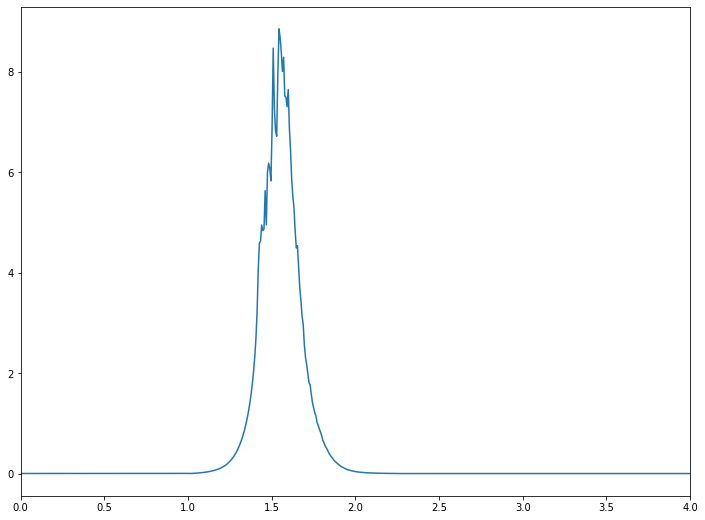

In [98]:
plt.figure(figsize=(12,9))
plt.plot(energies,px_ref_1e6_ft)
plt.xlim(0,4)

### FT of the echo signal

The maximum value of the energy in the  FT domain is given by 

In [99]:
dt = time[1]-time[0]
emax = h/(2*dt)
emax

20.678338479999997

In [100]:
dt = time[1]-time[0]
N = len(time)
freqs = np.fft.fftfreq(N,d=dt)
energies = h*freqs[0:int(N/2)]
pulseFT = np.fft.fft(echo_1e6_sel)[0:int(N/2)]
echo_1e6_sel_ft = np.sqrt(pulseFT.real**2+pulseFT.imag**2)

(0.0, 4.0)

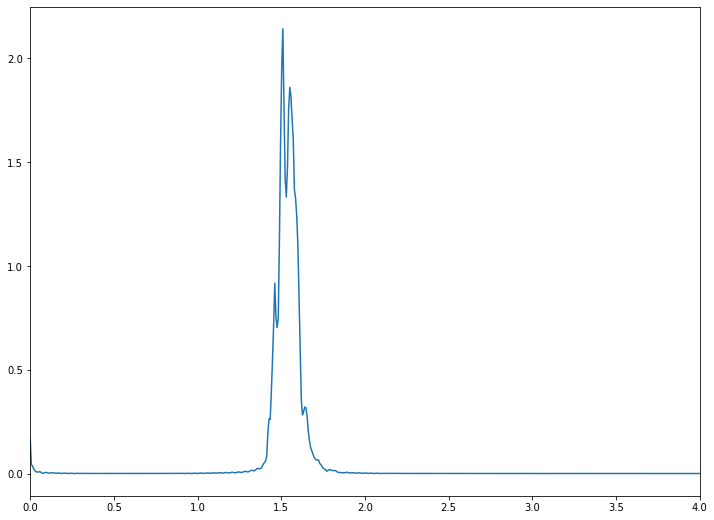

In [101]:
plt.figure(figsize=(12,9))
plt.plot(energies,echo_1e6_sel_ft)
plt.xlim(0,4)

### Analysis of the carriers

We analyze the carriers and the non-equilibrium occupation level

In [102]:
output = P.YamboOutputParser([file_car])
carriers_1e6 = output['carriers']['dne']

Parse file RT_Echo_k1000_kspan0.06/FixSymm/100fs-direct-int_1e6_1e6-omega_1.58-fwhm_10/o-100fs-direct-int_1e6_1e6-omega_1.58-fwhm_10.carriers


We also plot the carriers

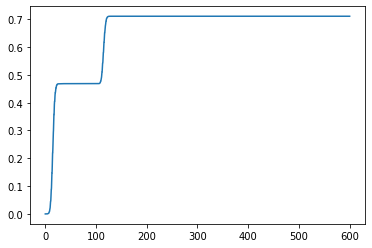

In [103]:
plt.plot(time,carriers_1e6)

We analyze the RT_Carriers

In [54]:
occ = U.get_variable_from_db(ndb_car,'RT_carriers_delta_f')
ntime,nstates = occ.shape
ntime,nstates

(61, 83895)

In [55]:
time_ndb = np.linspace(0,6,ntime)

In [56]:
rt_bands = 7

In [57]:
def fetch_band_indexes(nstates,rt_bands,band):
    numk = int(nstates/rt_bands)
    indexes = [k*rt_bands+band for k in range(numk)]
    return indexes

In [58]:
c1_ind = fetch_band_indexes(nstates,rt_bands,3)
c2_ind = fetch_band_indexes(nstates,rt_bands,4)
c3_ind = fetch_band_indexes(nstates,rt_bands,5)
c4_ind = fetch_band_indexes(nstates,rt_bands,6)


c1 = occ[:,c1_ind]
c2 = occ[:,c2_ind]
c3 = occ[:,c3_ind]
c4 = occ[:,c4_ind]

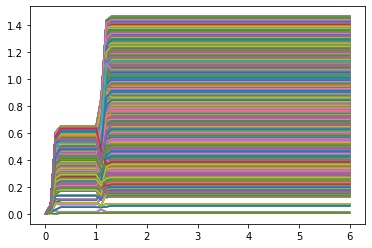

In [59]:
for k in range(len(c1[0])):
    plt.plot(time_ndb,c1[:,k])

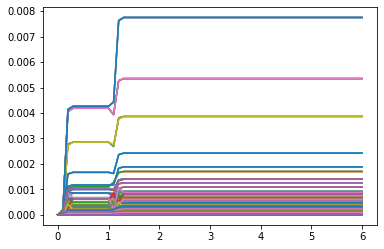

In [60]:
for k in range(len(c1[0])):
    plt.plot(time_ndb,c2[:,k])

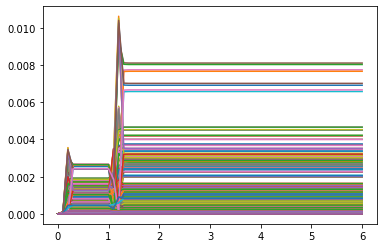

In [61]:
for k in range(len(c1[0])):
    plt.plot(time_ndb,c3[:,k])

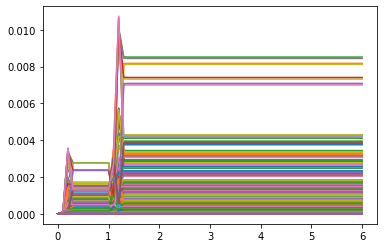

In [62]:
for k in range(len(c1[0])):
    plt.plot(time_ndb,c4[:,k])